<a href="https://colab.research.google.com/github/yizhangzhai/New/blob/main/Untitled8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

data = pd.read_json("/content/drive/MyDrive/transactions.txt", orient='records',lines=True)
data = data.sort_values(by=['accountNumber', 'transactionDateTime'])

In [3]:
list(data.columns)

['accountNumber',
 'customerId',
 'creditLimit',
 'availableMoney',
 'transactionDateTime',
 'transactionAmount',
 'merchantName',
 'acqCountry',
 'merchantCountryCode',
 'posEntryMode',
 'posConditionCode',
 'merchantCategoryCode',
 'currentExpDate',
 'accountOpenDate',
 'dateOfLastAddressChange',
 'cardCVV',
 'enteredCVV',
 'cardLast4Digits',
 'transactionType',
 'echoBuffer',
 'currentBalance',
 'merchantCity',
 'merchantState',
 'merchantZip',
 'cardPresent',
 'posOnPremises',
 'recurringAuthInd',
 'expirationDateKeyInMatch',
 'isFraud']

In [4]:
import tqdm

merchants = pd.DataFrame()

for M in tqdm.tqdm(data.merchantName.unique()):
    temp = pd.DataFrame({'transactionDateTime': pd.date_range(start='2016-01-01', end='2016-12-31', freq='D')})
    temp['merchantName'] = M
    merchants = pd.concat([merchants, temp], axis=0)

merchants['transactionDateTime'] = merchants['transactionDateTime'].astype(str)


merchants_real = data[['transactionDateTime', 'merchantName', 'isFraud', 'transactionAmount']]
merchants_real['transactionDateTime'] = [str(t).split('T')[0] for t in merchants_real['transactionDateTime'].values]

merchants_real_fraud = merchants_real[['merchantName', 'transactionDateTime', 'isFraud']].groupby(['merchantName', 'transactionDateTime'])['isFraud'].agg(['count', 'sum']).reset_index()
merchants_real_amout = merchants_real[['merchantName', 'transactionDateTime', 'transactionAmount']].groupby(['merchantName', 'transactionDateTime'])['transactionAmount'].agg(['mean', 'max']).reset_index()

100%|██████████| 2490/2490 [00:17<00:00, 138.87it/s]
<ipython-input-4-e132a4e23181>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merchants_real['transactionDateTime'] = [str(t).split('T')[0] for t in merchants_real['transactionDateTime'].values]


In [5]:
merchants30 = merchants.merge(merchants_real_fraud, how='left', on=['transactionDateTime', 'merchantName'])
merchants30['transactionDateTime'] = pd.to_datetime(merchants30['transactionDateTime'])

merchants30 = merchants30.groupby('merchantName').rolling(window='30D', on='transactionDateTime', closed='left')['count', 'sum'].sum().reset_index()
merchants30['fraud_risk_hist30'] = merchants30['sum'] / merchants30['count']
merchants30.columns = ['merchantName', 'transactionDateTime', 'total_count_hist30', 'fraud_count_hist30', 'fraud_risk_hist30']

merchants30['transactionDateTime_s'] = merchants30['transactionDateTime'].astype(str)

In [6]:
merchants07 = merchants.merge(merchants_real_fraud, how='left', on=['transactionDateTime', 'merchantName'])
merchants07['transactionDateTime'] = pd.to_datetime(merchants07['transactionDateTime'])

merchants07 = merchants07.groupby('merchantName').rolling(window='7D', on='transactionDateTime', closed='left')['count', 'sum'].sum().reset_index()
merchants07['fraud_risk_hist07'] = merchants07['sum'] / merchants07['count']
merchants07.columns = ['merchantName', 'transactionDateTime', 'total_count_hist07', 'fraud_count_hist07', 'fraud_risk_hist07']

merchants07['transactionDateTime_s'] = merchants07['transactionDateTime'].astype(str)

In [7]:
merchants30_amout = merchants.merge(merchants_real_amout, how='left', on=['transactionDateTime', 'merchantName'])
merchants30_amout['transactionDateTime'] = pd.to_datetime(merchants30_amout['transactionDateTime'])

merchants30_amout = merchants30_amout.groupby('merchantName').rolling(window='30D', on='transactionDateTime', closed='left')['mean', 'max'].sum().reset_index()
merchants30_amout.columns = ['merchantName', 'transactionDateTime', 'merchant_transAmount_hist30_mean', 'merchant_transAmount_hist30_max']

merchants30_amout['transactionDateTime_s'] = merchants30_amout['transactionDateTime'].astype(str)

In [8]:
merchants07_amout = merchants.merge(merchants_real_amout, how='left', on=['transactionDateTime', 'merchantName'])
merchants07_amout['transactionDateTime'] = pd.to_datetime(merchants07_amout['transactionDateTime'])

merchants07_amout = merchants07_amout.groupby('merchantName').rolling(window='7D', on='transactionDateTime', closed='left')['mean', 'max'].sum().reset_index()
merchants07_amout.columns = ['merchantName', 'transactionDateTime', 'merchant_transAmount_hist07_mean', 'merchant_transAmount_hist07_max']

merchants07_amout['transactionDateTime_s'] = merchants07_amout['transactionDateTime'].astype(str)

In [9]:
data['transactionDateTime_dt'] = pd.to_datetime([dt.split('T')[0] for dt in data['transactionDateTime'].astype(str)])

account_roll30 = data.groupby('accountNumber').rolling(window='30D', on='transactionDateTime_dt', closed='left')
account_roll30_spending = account_roll30['transactionAmount'].agg(['mean', 'max', 'count', 'min', 'var'])
account_roll30_spending.columns = ["spending_hist30_mean", "spending_hist30_max", "spending_hist30_count", "spending_hist30_min", "spending_hist30_var"]
account_roll30_spending = account_roll30_spending.reset_index()
account_roll30_spending['transactionDateTime_s'] = account_roll30_spending['transactionDateTime_dt'].astype(str)

In [10]:
account_roll60 = data.groupby('accountNumber').rolling(window='60D', on='transactionDateTime_dt', closed='left')
account_roll60_spending = account_roll60['transactionAmount'].agg(['mean', 'max', 'count', 'min', 'var'])
account_roll60_spending.columns = ["spending_hist60_mean", "spending_hist60_max", "spending_hist60_count", "spending_hist60_min", "spending_hist60_var"]
account_roll60_spending = account_roll60_spending.reset_index()
account_roll60_spending['transactionDateTime_s'] = account_roll60_spending['transactionDateTime_dt'].astype(str)

In [11]:
account_roll07 = data.groupby('accountNumber').rolling(window='7D', on='transactionDateTime_dt', closed='left')
account_roll07_spending = account_roll07['transactionAmount'].agg(['mean', 'max', 'count', 'min', 'var'])
account_roll07_spending.columns = ["spending_hist07_mean", "spending_hist07_max", "spending_hist07_count", "spending_hist07_min", "spending_hist07_var"]
account_roll07_spending = account_roll07_spending.reset_index()
account_roll07_spending['transactionDateTime_s'] = account_roll07_spending['transactionDateTime_dt'].astype(str)

In [12]:
# account_last1 = data.groupby('accountNumber').rolling(window=1, closed='left')
# account_last1_spending = account_last1['transactionAmount'].mean()
# account_last1_spending = account_last1_spending.reset_index(level=0)
# account_last1_spending.columns = ["accountNumber", "spending_last1_mean"]
# account_last1_spending['transactionDateTime_s'] = [dt.split("T")[0] for dt in data['transactionDateTime'].astype(str)]
# account_last1_spending['transactionDateTime_t'] = pd.to_datetime(data['transactionDateTime'].astype(str))

In [13]:
# account_last1_spending["transactionDateTime_t_last"] = account_last1_spending.groupby('accountNumber')['transactionDateTime_t'].shift(1)
# account_last1_spending["transactionDateTime_t_diff_minutes"] = (account_last1_spending['transactionDateTime_t'] - account_last1_spending['transactionDateTime_t_last']).dt.total_seconds() / 60

In [ ]:
# account_based =  data[['accountNumber', 'transactionDateTime', 'transactionAmount']]
# transactionDateTime_t_last1 = account_based.groupby('accountNumber')['transactionDateTime'].shift(1)
# transactionDateTime_t_last5 = account_based.groupby('accountNumber')['transactionDateTime'].shift(5)
# transactionDateTime_t_last10 = account_based.groupby('accountNumber')['transactionDateTime'].shift(10)

# account_based['transactionDateTime_t_last1'] = transactionDateTime_t_last1
# account_based['transactionDateTime_t_last5'] = transactionDateTime_t_last5
# account_based['transactionDateTime_t_last10'] = transactionDateTime_t_last10

# account_based["transactionDateTime_t_last1_diff_minutes"] = (account_based['transactionDateTime'] - account_based['transactionDateTime_t_last1']).dt.total_seconds() / 60

In [12]:
account_last1_trans_date = data.groupby('accountNumber')["transactionDateTime"].shift(1)
account_last5_trans_date = data.groupby('accountNumber')["transactionDateTime"].shift(5)
data['account_last1_trans_date'] = account_last1_trans_date
data['account_last5_trans_date'] = account_last5_trans_date
data['account_last1_trans_date_diff'] = (pd.to_datetime(data['transactionDateTime']) - pd.to_datetime(data['account_last1_trans_date'])).dt.total_seconds() / 60
data['account_last5_trans_date_diff'] = (pd.to_datetime(data['transactionDateTime']) - pd.to_datetime(data['account_last5_trans_date'])).dt.total_seconds() / 60

In [ ]:
# account_last5 = data.groupby('accountNumber').rolling(window=5, closed='left')
# account_last5_spending = account_last5['transactionAmount'].agg(['mean', 'max'])
# account_last5_spending = account_last5_spending.reset_index(level=0)
# account_last5_spending.columns = ["accountNumber", "spending_last5_mean", "spending_last5_max"]
# account_last5_spending['transactionDateTime_s'] = [dt.split("T")[0] for dt in data['transactionDateTime'].astype(str)]
# account_last5_spending['transactionDateTime_t'] = pd.to_datetime(data['transactionDateTime'].astype(str))

In [13]:
account_last5 = data.groupby('accountNumber').rolling(window=5, closed='left')
account_last5 = account_last5['transactionAmount', 'account_last1_trans_date_diff'].agg(['mean', 'max', 'min', 'var'])
account_last5.columns = ['last5_'+a+'__'+b for a, b in account_last5.columns]
account_last5 = account_last5.reset_index(level=0)
account_last5['transactionDateTime_s'] = [dt.split("T")[0] for dt in data['transactionDateTime'].astype(str)]
account_last5['transactionDateTime_t'] = pd.to_datetime(data['transactionDateTime'].astype(str))

In [14]:
account_last1 = data.groupby('accountNumber').rolling(window=1, closed='left')
account_last1 = account_last1['transactionAmount', 'account_last1_trans_date_diff'].agg(['mean', 'max', 'min', 'var'])
account_last1.columns = ['last1_'+a+'__'+b for a, b in account_last1.columns]
account_last1 = account_last1.reset_index(level=0)
account_last1['transactionDateTime_s'] = [dt.split("T")[0] for dt in data['transactionDateTime'].astype(str)]
account_last1['transactionDateTime_t'] = pd.to_datetime(data['transactionDateTime'].astype(str))

In [16]:
date_map = {str(dt).split(' ')[0]:i for i, dt in enumerate(sorted(data.transactionDateTime_dt.unique()))}
data['hist_merchants_visit_mapped'] = [str(t).split('T')[0] for t in data['transactionDateTime_dt'].values]
data['hist_merchants_visit_mapped'] = data['hist_merchants_visit_mapped'].astype(str).map(date_map)
hist_merchants_visit = data[['accountNumber', 'merchantName', 'hist_merchants_visit_mapped']].groupby(['accountNumber', 'merchantName'])['hist_merchants_visit_mapped'].apply(lambda x: (x.astype(str).tolist())).reset_index()

from collections import defaultdict, Counter
import torch

hist_merchants_visit_dict = defaultdict(lambda: defaultdict(list))

for accountNumber, merchantName, hist_merchants_visit_mapped in tqdm.tqdm(hist_merchants_visit.values):
      tensor = torch.zeros(len(date_map), dtype=torch.int)
      temp_dict = Counter(hist_merchants_visit_mapped)
      for k, v in temp_dict.items():
          tensor[int(k)] = v
      hist_merchants_visit_dict[str(accountNumber)][merchantName].append(tensor)

100%|██████████| 208887/208887 [00:09<00:00, 21582.58it/s]


In [17]:
visits = []
for accountNumber, transactionDateTime_dt, merchantName in tqdm.tqdm(data[['accountNumber', 'transactionDateTime_dt', 'merchantName']].values):
      cnt_1, cnt_10, cnt_30, cnt_total = 0, 0, 0, 0
      if str(accountNumber) in hist_merchants_visit_dict:
              if str(merchantName) in hist_merchants_visit_dict[str(accountNumber)]:
                        transactionDateTime_dt = str(transactionDateTime_dt).split(' ')[0]
                        hist_visits = hist_merchants_visit_dict[str(accountNumber)][str(merchantName)][0]
                        query_dt_index = date_map[transactionDateTime_dt]

                        mask_total = torch.tensor([1]*query_dt_index + [0]*(365-query_dt_index), dtype=torch.int)
                        mask_30 = torch.zeros(365, dtype=torch.int)
                        mask_30[max(0,query_dt_index-30):query_dt_index] = 1
                        mask_10 = torch.zeros(365, dtype=torch.int)
                        mask_10[max(0,query_dt_index-10):query_dt_index] = 1
                        mask_1 = torch.zeros(365, dtype=torch.int)
                        mask_1[query_dt_index] = 1

                        cnt_total += int(hist_visits @ mask_total)
                        cnt_30 += int(hist_visits @ mask_30)
                        cnt_10 += int(hist_visits @ mask_10)
                        cnt_1  += int(hist_visits @ mask_1)

      visits.append([cnt_1, cnt_10, cnt_30, cnt_total])

100%|██████████| 786363/786363 [01:55<00:00, 6801.92it/s]


In [18]:
import numpy as np
visits = np.array(visits)

In [362]:
visits

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [1, 0, 0, 3],
       [1, 0, 0, 4],
       [1, 0, 1, 5]])

In [19]:
temp = data[['accountNumber', 'creditLimit','availableMoney','transactionAmount','currentBalance','merchantName','acqCountry','merchantCountryCode','cardCVV','enteredCVV', 'merchantCategoryCode',
             'dateOfLastAddressChange', 'transactionDateTime', 'currentExpDate', 'accountOpenDate', 'transactionType','cardPresent','expirationDateKeyInMatch','isFraud']]
# del data

temp['transactionDateTime_s'] = [x.split('T')[0] for x in temp['transactionDateTime'].astype(str).values]


temp = temp.merge(merchants30[['merchantName', 'transactionDateTime_s', 'total_count_hist30', 'fraud_count_hist30', 'fraud_risk_hist30']],
                  how='left', left_on = ['merchantName', 'transactionDateTime_s'], right_on = ['merchantName', 'transactionDateTime_s'])
# del merchants30

temp = temp.merge(merchants07[['merchantName', 'transactionDateTime_s', 'total_count_hist07', 'fraud_count_hist07', 'fraud_risk_hist07']],
                  how='left', left_on = ['merchantName', 'transactionDateTime_s'], right_on = ['merchantName', 'transactionDateTime_s'])
# del merchants07

temp = temp.merge(merchants30_amout[['merchantName', 'transactionDateTime_s', 'merchant_transAmount_hist30_mean', 'merchant_transAmount_hist30_max']],
                  how='left', left_on = ['merchantName', 'transactionDateTime_s'], right_on = ['merchantName', 'transactionDateTime_s'])
# del merchants30_amout

temp = temp.merge(merchants07_amout[['merchantName', 'transactionDateTime_s', 'merchant_transAmount_hist07_mean', 'merchant_transAmount_hist07_max']],
                  how='left', left_on = ['merchantName', 'transactionDateTime_s'], right_on = ['merchantName', 'transactionDateTime_s'])
# del merchants07_amout

# temp = temp.merge(account_roll30_spending[['accountNumber', 'transactionDateTime_s', "spending_hist30_mean", "spending_hist30_max", "spending_hist30_count", 'spending_hist30_min', 'spending_hist30_var']],
#                   how='left', left_on = ['accountNumber', 'transactionDateTime_s'], right_on = ['accountNumber', 'transactionDateTime_s']).drop_duplicates()
# del account_roll30_spending

temp['spending_hist30_mean'] = account_roll30_spending['spending_hist30_mean'].copy()
temp['spending_hist30_max'] = account_roll30_spending['spending_hist30_max'].copy()
temp['spending_hist30_count'] = account_roll30_spending['spending_hist30_count'].copy()
temp['spending_hist30_min'] = account_roll30_spending['spending_hist30_min'].copy()
temp['spending_hist30_var'] = account_roll30_spending['spending_hist30_var'].copy()

# temp = temp.merge(account_roll60_spending[['accountNumber', 'transactionDateTime_s', "spending_hist60_mean", "spending_hist60_max", "spending_hist60_count", 'spending_hist60_min', 'spending_hist60_var']],
#                   how='left', left_on = ['accountNumber', 'transactionDateTime_s'], right_on = ['accountNumber', 'transactionDateTime_s']).drop_duplicates()
# del account_roll60_spending

temp['spending_hist60_mean'] = account_roll60_spending['spending_hist60_mean'].copy()
temp['spending_hist60_max'] = account_roll60_spending['spending_hist60_max'].copy()
temp['spending_hist60_count'] = account_roll60_spending['spending_hist60_count'].copy()
temp['spending_hist60_min'] = account_roll60_spending['spending_hist60_min'].copy()
temp['spending_hist60_var'] = account_roll60_spending['spending_hist60_var'].copy()

# temp = temp.merge(account_roll07_spending[['accountNumber', 'transactionDateTime_s', 'spending_hist07_mean', 'spending_hist07_max', 'spending_hist07_count', 'spending_hist07_min', 'spending_hist07_var']],
#                   how='left', left_on = ['accountNumber', 'transactionDateTime_s'], right_on = ['accountNumber', 'transactionDateTime_s']).drop_duplicates()
# del account_roll07_spending

temp['spending_hist07_mean'] = account_roll07_spending['spending_hist07_mean'].copy()
temp['spending_hist07_max'] = account_roll07_spending['spending_hist07_max'].copy()
temp['spending_hist07_count'] = account_roll07_spending['spending_hist07_count'].copy()
temp['spending_hist07_min'] = account_roll07_spending['spending_hist07_min'].copy()
temp['spending_hist07_var'] = account_roll07_spending['spending_hist07_var'].copy()

# temp = temp.merge(account_last5[['accountNumber', 'last5_transactionAmount__mean',
#                                 'last5_transactionAmount__max', 'last5_transactionAmount__min',
#                                 'last5_transactionAmount__var',
#                                 'last5_account_last1_trans_date_diff__mean',
#                                 'last5_account_last1_trans_date_diff__max',
#                                 'last5_account_last1_trans_date_diff__min',
#                                 'last5_account_last1_trans_date_diff__var', 'transactionDateTime_s',]],
#                   how='left', left_on = ['accountNumber', 'transactionDateTime_s'], right_on = ['accountNumber', 'transactionDateTime_s']).drop_duplicates()
# del account_last5
temp['last5_transactionAmount__mean'] = account_last5['last5_transactionAmount__mean'].copy()
temp['last5_transactionAmount__max'] = account_last5['last5_transactionAmount__max'].copy()
temp['last5_transactionAmount__min'] = account_last5['last5_transactionAmount__min'].copy()
temp['last5_transactionAmount__var'] = account_last5['last5_transactionAmount__var'].copy()
temp['last5_account_last1_trans_date_diff__mean'] = account_last5['last5_account_last1_trans_date_diff__mean'].copy()
temp['last5_account_last1_trans_date_diff__max'] = account_last5['last5_account_last1_trans_date_diff__max'].copy()
temp['last5_account_last1_trans_date_diff__min'] = account_last5['last5_account_last1_trans_date_diff__min'].copy()
temp['last5_account_last1_trans_date_diff__var'] = account_last5['last5_account_last1_trans_date_diff__var'].copy()

# temp = temp.merge(account_last1[['accountNumber', 'last1_transactionAmount__mean',
#                                 'last1_transactionAmount__max', 'last1_transactionAmount__min',
#                                 'last1_transactionAmount__var',
#                                 'last1_account_last1_trans_date_diff__mean',
#                                 'last1_account_last1_trans_date_diff__max',
#                                 'last1_account_last1_trans_date_diff__min',
#                                 'last1_account_last1_trans_date_diff__var', 'transactionDateTime_s']],
#                   how='left', left_on = ['accountNumber', 'transactionDateTime_s'], right_on = ['accountNumber', 'transactionDateTime_s']).drop_duplicates()
# del account_last1

temp['last1_transactionAmount__mean'] = account_last1['last1_transactionAmount__mean'].copy()
temp['last1_account_last1_trans_date_diff__mean'] = account_last1['last1_account_last1_trans_date_diff__mean'].copy()

<ipython-input-19-ac0ce6bf4d1e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['transactionDateTime_s'] = [x.split('T')[0] for x in temp['transactionDateTime'].astype(str).values]


In [22]:
OOT.isFraud.sum(), sum(Y_train), sum(Y_val)

NameError: name 'OOT' is not defined

In [24]:
from sklearn.model_selection import train_test_split
OOT = temp.loc[temp.transactionDateTime>='2016-11-01']
X_train, X_val, Y_train, Y_val = train_test_split(temp.loc[temp.transactionDateTime<'2016-11-01'], temp.loc[temp.transactionDateTime<'2016-11-01'].isFraud, random_state=321, test_size=0.2)

In [25]:
for c in ['merchantName','acqCountry','merchantCountryCode','transactionType','merchantCategoryCode']:
    cat_dict = {v:i for i, v in enumerate(X_train[c].unique())}
    X_train[c] = X_train[c].map(cat_dict)
    X_val[c] = X_val[c].map(cat_dict)
    OOT[c] = OOT[c].map(cat_dict)

<ipython-input-25-f8db7d3b3989>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OOT[c] = OOT[c].map(cat_dict)
<ipython-input-25-f8db7d3b3989>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OOT[c] = OOT[c].map(cat_dict)
<ipython-input-25-f8db7d3b3989>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

In [26]:
X_train['cardPresent'] = X_train['cardPresent'].map({True:1, False:0})
X_train['expirationDateKeyInMatch'] = X_train['expirationDateKeyInMatch'].map({True:1, False:0})

X_val['cardPresent'] = X_val['cardPresent'].map({True:1, False:0})
X_val['expirationDateKeyInMatch'] = X_val['expirationDateKeyInMatch'].map({True:1, False:0})

OOT['cardPresent'] = OOT['cardPresent'].map({True:1, False:0})
OOT['expirationDateKeyInMatch'] = OOT['expirationDateKeyInMatch'].map({True:1, False:0})

<ipython-input-26-7925b043c7df>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OOT['cardPresent'] = OOT['cardPresent'].map({True:1, False:0})
<ipython-input-26-7925b043c7df>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OOT['expirationDateKeyInMatch'] = OOT['expirationDateKeyInMatch'].map({True:1, False:0})


In [27]:
X_train['CVV_match'] = (X_train.cardCVV == X_train.enteredCVV) + 0
X_val['CVV_match'] = (X_val.cardCVV == X_val.enteredCVV) + 0
OOT['CVV_match'] = (OOT.cardCVV == OOT.enteredCVV) + 0

<ipython-input-27-90dc290261b8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OOT['CVV_match'] = (OOT.cardCVV == OOT.enteredCVV) + 0


In [28]:
X_train['transactionDateTime'] = pd.to_datetime(X_train['transactionDateTime'])
X_val['transactionDateTime'] = pd.to_datetime(X_val['transactionDateTime'])
OOT['transactionDateTime'] = pd.to_datetime(OOT['transactionDateTime'])

X_train['accountOpenDate'] = pd.to_datetime(X_train['accountOpenDate'])
X_val['accountOpenDate'] = pd.to_datetime(X_val['accountOpenDate'])
OOT['accountOpenDate'] = pd.to_datetime(OOT['accountOpenDate'])

X_train['dateOfLastAddressChange'] = pd.to_datetime(X_train['dateOfLastAddressChange'])
X_val['dateOfLastAddressChange'] = pd.to_datetime(X_val['dateOfLastAddressChange'])
OOT['dateOfLastAddressChange'] = pd.to_datetime(OOT['dateOfLastAddressChange'])

X_train['currentExpDate'] = pd.to_datetime(X_train['currentExpDate'])
X_val['currentExpDate'] = pd.to_datetime(X_val['currentExpDate'])
OOT['currentExpDate'] = pd.to_datetime(OOT['currentExpDate'])

<ipython-input-28-44c06b27de65>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OOT['transactionDateTime'] = pd.to_datetime(OOT['transactionDateTime'])
<ipython-input-28-44c06b27de65>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OOT['accountOpenDate'] = pd.to_datetime(OOT['accountOpenDate'])
<ipython-input-28-44c06b27de65>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [29]:
X_train['transaction_since_open'] = (X_train['transactionDateTime'] - X_train['accountOpenDate']).dt.days
X_train['transaction_since_lastAddrChange'] = (X_train['transactionDateTime'] - X_train['dateOfLastAddressChange']).dt.days
X_train['lastAddrChange_since_open'] = (X_train['dateOfLastAddressChange'] - X_train['accountOpenDate']).dt.days

X_val['transaction_since_open'] = (X_val['transactionDateTime'] - X_val['accountOpenDate']).dt.days
X_val['transaction_since_lastAddrChange'] = (X_val['transactionDateTime'] - X_val['dateOfLastAddressChange']).dt.days
X_val['lastAddrChange_since_open'] = (X_val['dateOfLastAddressChange'] - X_val['accountOpenDate']).dt.days

OOT['transaction_since_open'] = (OOT['transactionDateTime'] - OOT['accountOpenDate']).dt.days
OOT['transaction_since_lastAddrChange'] = (OOT['transactionDateTime'] - OOT['dateOfLastAddressChange']).dt.days
OOT['lastAddrChange_since_open'] = (OOT['dateOfLastAddressChange'] - OOT['accountOpenDate']).dt.days

<ipython-input-29-7c4a54eaaa64>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OOT['transaction_since_open'] = (OOT['transactionDateTime'] - OOT['accountOpenDate']).dt.days
<ipython-input-29-7c4a54eaaa64>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OOT['transaction_since_lastAddrChange'] = (OOT['transactionDateTime'] - OOT['dateOfLastAddressChange']).dt.days
<ipython-input-29-7c4a54eaaa64>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [30]:
X_train['transaction_ratio'] = X_train['transactionAmount']/X_train['creditLimit']
X_val['transaction_ratio'] = X_val['transactionAmount']/X_val['creditLimit']
OOT['transaction_ratio'] = OOT['transactionAmount']/OOT['creditLimit']

<ipython-input-30-dc396a57de06>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OOT['transaction_ratio'] = OOT['transactionAmount']/OOT['creditLimit']


In [31]:
X_train['util'] = X_train['availableMoney']/X_train['creditLimit']
X_val['util'] = X_val['availableMoney']/X_val['creditLimit']
OOT['util'] = OOT['availableMoney']/OOT['creditLimit']

<ipython-input-31-6c63161659a0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OOT['util'] = OOT['availableMoney']/OOT['creditLimit']


In [32]:
X_train['spending_hist30_mean_diff'] = X_train['transactionAmount'] - X_train['spending_hist30_mean']
X_val['spending_hist30_mean_diff'] = X_val['transactionAmount'] - X_val['spending_hist30_mean']
OOT['spending_hist30_mean_diff'] = OOT['transactionAmount'] - OOT['spending_hist30_mean']

X_train['spending_hist30_max_diff'] = X_train['spending_hist30_max'] - X_train['transactionAmount']
X_val['spending_hist30_max_diff'] = X_val['spending_hist30_max'] - X_val['transactionAmount']
OOT['spending_hist30_max_diff'] = OOT['spending_hist30_max'] - OOT['transactionAmount']

<ipython-input-32-e2ca9989988e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OOT['spending_hist30_mean_diff'] = OOT['transactionAmount'] - OOT['spending_hist30_mean']
<ipython-input-32-e2ca9989988e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OOT['spending_hist30_max_diff'] = OOT['spending_hist30_max'] - OOT['transactionAmount']


In [33]:
X_train['spending_hist60_mean_diff'] = X_train['transactionAmount'] - X_train['spending_hist60_mean']
X_val['spending_hist60_mean_diff'] = X_val['transactionAmount'] - X_val['spending_hist60_mean']
OOT['spending_hist60_mean_diff'] = OOT['transactionAmount'] - OOT['spending_hist60_mean']

X_train['spending_hist60_max_diff'] = X_train['spending_hist60_max'] - X_train['transactionAmount']
X_val['spending_hist60_max_diff'] = X_val['spending_hist60_max'] - X_val['transactionAmount']
OOT['spending_hist60_max_diff'] = OOT['spending_hist60_max'] - OOT['transactionAmount']

<ipython-input-33-5d947d4d6d0c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OOT['spending_hist60_mean_diff'] = OOT['transactionAmount'] - OOT['spending_hist60_mean']
<ipython-input-33-5d947d4d6d0c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OOT['spending_hist60_max_diff'] = OOT['spending_hist60_max'] - OOT['transactionAmount']


In [34]:
X_train['spending_hist07_mean_diff'] = X_train['transactionAmount'] - X_train['spending_hist07_mean']
X_val['spending_hist07_mean_diff'] = X_val['transactionAmount'] - X_val['spending_hist07_mean']
OOT['spending_hist07_mean_diff'] = OOT['transactionAmount'] - OOT['spending_hist07_mean']

X_train['spending_hist07_max_diff'] = X_train['spending_hist07_max'] - X_train['transactionAmount']
X_val['spending_hist07_max_diff'] = X_val['spending_hist07_max'] - X_val['transactionAmount']
OOT['spending_hist07_max_diff'] = OOT['spending_hist07_max'] - OOT['transactionAmount']

<ipython-input-34-b27d0596126e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OOT['spending_hist07_mean_diff'] = OOT['transactionAmount'] - OOT['spending_hist07_mean']
<ipython-input-34-b27d0596126e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OOT['spending_hist07_max_diff'] = OOT['spending_hist07_max'] - OOT['transactionAmount']


In [35]:
X_train['spending_hist07_mean_R'] = X_train['transactionAmount'] / X_train['spending_hist07_mean']
X_val['spending_hist07_mean_R'] = X_val['transactionAmount'] / X_val['spending_hist07_mean']
OOT['spending_hist07_mean_R'] = OOT['transactionAmount'] / OOT['spending_hist07_mean']

X_train['spending_hist07_max_R'] = X_train['transactionAmount'] / X_train['spending_hist07_max']
X_val['spending_hist07_max_R'] = X_val['transactionAmount'] / X_val['spending_hist07_max']
OOT['spending_hist07_max_R'] = OOT['transactionAmount'] / OOT['spending_hist07_max']

<ipython-input-35-8aa6087449a7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OOT['spending_hist07_mean_R'] = OOT['transactionAmount'] / OOT['spending_hist07_mean']
<ipython-input-35-8aa6087449a7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OOT['spending_hist07_max_R'] = OOT['transactionAmount'] / OOT['spending_hist07_max']


In [36]:
X_train['spending_hist30_mean_R'] = X_train['transactionAmount'] / X_train['spending_hist30_mean']
X_val['spending_hist30_mean_R'] = X_val['transactionAmount'] / X_val['spending_hist30_mean']
OOT['spending_hist30_mean_R'] = OOT['transactionAmount'] / OOT['spending_hist30_mean']

X_train['spending_hist30_max_R'] = X_train['transactionAmount'] / X_train['spending_hist30_max']
X_val['spending_hist30_max_R'] = X_val['transactionAmount'] / X_val['spending_hist30_max']
OOT['spending_hist30_max_R'] = OOT['transactionAmount'] / OOT['spending_hist30_max']

<ipython-input-36-35cc3aca67ae>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OOT['spending_hist30_mean_R'] = OOT['transactionAmount'] / OOT['spending_hist30_mean']
<ipython-input-36-35cc3aca67ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OOT['spending_hist30_max_R'] = OOT['transactionAmount'] / OOT['spending_hist30_max']


In [37]:
X_train['merchant_transAmount_hist30_mean_R'] = X_train['transactionAmount'] / X_train['merchant_transAmount_hist30_mean']
X_val['merchant_transAmount_hist30_mean_R'] = X_val['transactionAmount'] / X_val['merchant_transAmount_hist30_mean']
OOT['merchant_transAmount_hist30_mean_R'] = OOT['transactionAmount'] / OOT['merchant_transAmount_hist30_mean']

X_train['merchant_transAmount_hist30_max_R'] = X_train['transactionAmount'] / X_train['merchant_transAmount_hist30_max']
X_val['merchant_transAmount_hist30_max_R'] = X_val['transactionAmount'] / X_val['merchant_transAmount_hist30_max']
OOT['merchant_transAmount_hist30_max_R'] = OOT['transactionAmount'] / OOT['merchant_transAmount_hist30_max']

<ipython-input-37-e407536ffb52>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OOT['merchant_transAmount_hist30_mean_R'] = OOT['transactionAmount'] / OOT['merchant_transAmount_hist30_mean']
<ipython-input-37-e407536ffb52>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OOT['merchant_transAmount_hist30_max_R'] = OOT['transactionAmount'] / OOT['merchant_transAmount_hist30_max']


In [38]:
X_train['merchant_transAmount_hist07_mean_R'] = X_train['transactionAmount'] / X_train['merchant_transAmount_hist07_mean']
X_val['merchant_transAmount_hist07_mean_R'] = X_val['transactionAmount'] / X_val['merchant_transAmount_hist07_mean']
OOT['merchant_transAmount_hist07_mean_R'] = OOT['transactionAmount'] / OOT['merchant_transAmount_hist07_mean']

X_train['merchant_transAmount_hist07_max_R'] = X_train['transactionAmount'] / X_train['merchant_transAmount_hist07_max']
X_val['merchant_transAmount_hist07_max_R'] = X_val['transactionAmount'] / X_val['merchant_transAmount_hist07_max']
OOT['merchant_transAmount_hist07_max_R'] = OOT['transactionAmount'] / OOT['merchant_transAmount_hist07_max']

<ipython-input-38-d0d04664d824>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OOT['merchant_transAmount_hist07_mean_R'] = OOT['transactionAmount'] / OOT['merchant_transAmount_hist07_mean']
<ipython-input-38-d0d04664d824>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OOT['merchant_transAmount_hist07_max_R'] = OOT['transactionAmount'] / OOT['merchant_transAmount_hist07_max']


In [39]:
X_train['last5_transactionAmount__mean_R'] = X_train['transactionAmount'] / X_train['last5_transactionAmount__mean']
X_val['last5_transactionAmount__mean_R'] = X_val['transactionAmount'] / X_val['last5_transactionAmount__mean']
OOT['last5_transactionAmount__mean_R'] = OOT['transactionAmount'] / OOT['last5_transactionAmount__mean']

X_train['last5_transactionAmount__mean_diff'] = X_train['transactionAmount'] - X_train['last5_transactionAmount__mean']
X_val['last5_transactionAmount__mean_diff'] = X_val['transactionAmount'] - X_val['last5_transactionAmount__mean']
OOT['last5_transactionAmount__mean_diff'] = OOT['transactionAmount'] - OOT['last5_transactionAmount__mean']

<ipython-input-39-c44ed4e1ca85>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OOT['last5_transactionAmount__mean_R'] = OOT['transactionAmount'] / OOT['last5_transactionAmount__mean']
<ipython-input-39-c44ed4e1ca85>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OOT['last5_transactionAmount__mean_diff'] = OOT['transactionAmount'] - OOT['last5_transactionAmount__mean']


In [40]:
X_train['last5_transactionAmount__max_R'] = X_train['transactionAmount'] / X_train['last5_transactionAmount__max']
X_val['last5_transactionAmount__max_R'] = X_val['transactionAmount'] / X_val['last5_transactionAmount__max']
OOT['last5_transactionAmount__max_R'] = OOT['transactionAmount'] / OOT['last5_transactionAmount__max']

X_train['last5_transactionAmount__max_diff'] = X_train['transactionAmount'] - X_train['last5_transactionAmount__max']
X_val['last5_transactionAmount__max_diff'] = X_val['transactionAmount'] - X_val['last5_transactionAmount__max']
OOT['last5_transactionAmount__max_diff'] = OOT['transactionAmount'] - OOT['last5_transactionAmount__max']

<ipython-input-40-4031fad7599e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OOT['last5_transactionAmount__max_R'] = OOT['transactionAmount'] / OOT['last5_transactionAmount__max']
<ipython-input-40-4031fad7599e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OOT['last5_transactionAmount__max_diff'] = OOT['transactionAmount'] - OOT['last5_transactionAmount__max']


In [41]:
X_train['last5_transactionAmount__min_R'] = X_train['transactionAmount'] / X_train['last5_transactionAmount__min']
X_val['last5_transactionAmount__min_R'] = X_val['transactionAmount'] / X_val['last5_transactionAmount__min']
OOT['last5_transactionAmount__min_R'] = OOT['transactionAmount'] / OOT['last5_transactionAmount__min']

X_train['last5_transactionAmount__min_diff'] = X_train['transactionAmount'] - X_train['last5_transactionAmount__min']
X_val['last5_transactionAmount__min_diff'] = X_val['transactionAmount'] - X_val['last5_transactionAmount__min']
OOT['last5_transactionAmount__min_diff'] = OOT['transactionAmount'] - OOT['last5_transactionAmount__min']

<ipython-input-41-21ccc0241f96>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OOT['last5_transactionAmount__min_R'] = OOT['transactionAmount'] / OOT['last5_transactionAmount__min']
<ipython-input-41-21ccc0241f96>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OOT['last5_transactionAmount__min_diff'] = OOT['transactionAmount'] - OOT['last5_transactionAmount__min']


In [42]:
X_train['last1_transactionAmount__mean_R'] = X_train['transactionAmount'] / X_train['last1_transactionAmount__mean']
X_val['last1_transactionAmount__mean_R'] = X_val['transactionAmount'] / X_val['last1_transactionAmount__mean']
OOT['last1_transactionAmount__mean_R'] = OOT['transactionAmount'] / OOT['last1_transactionAmount__mean']

X_train['last1_transactionAmount__mean_diff'] = X_train['transactionAmount'] - X_train['last1_transactionAmount__mean']
X_val['last1_transactionAmount__mean_diff'] = X_val['transactionAmount'] - X_val['last1_transactionAmount__mean']
OOT['last1_transactionAmount__mean_diff'] = OOT['transactionAmount'] - OOT['last1_transactionAmount__mean']

<ipython-input-42-8a851e1c81d9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OOT['last1_transactionAmount__mean_R'] = OOT['transactionAmount'] / OOT['last1_transactionAmount__mean']
<ipython-input-42-8a851e1c81d9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OOT['last1_transactionAmount__mean_diff'] = OOT['transactionAmount'] - OOT['last1_transactionAmount__mean']


In [43]:
X_train['visit_merchant_last_10_day_vs_all_R'] = X_train['visit_merchant_last_10_day']/X_train['visit_merchant_all_before']
X_val['visit_merchant_last_10_day_vs_all_R'] = X_val['visit_merchant_last_10_day']/X_val['visit_merchant_all_before']
OOT['visit_merchant_last_10_day_vs_all_R'] = OOT['visit_merchant_last_10_day']/OOT['visit_merchant_all_before']

<ipython-input-43-1b1714ee9315>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OOT['visit_merchant_last_10_day_vs_all_R'] = OOT['visit_merchant_last_10_day']/OOT['visit_merchant_all_before']


In [45]:
cols = ['creditLimit','availableMoney','transactionAmount','acqCountry','merchantCountryCode','transactionType','cardPresent','merchantCategoryCode',
        'expirationDateKeyInMatch','CVV_match','transaction_since_open','transaction_since_lastAddrChange','lastAddrChange_since_open',

        'transaction_ratio', 'util',

        'visit_merchant_last_1_day','visit_merchant_last_10_day','visit_merchant_last_30_day','visit_merchant_all_before',

        "total_count_hist30",	"fraud_count_hist30","fraud_risk_hist30", "total_count_hist07",	"fraud_count_hist07","fraud_risk_hist07",
        'merchant_transAmount_hist30_mean', 'merchant_transAmount_hist30_max','merchant_transAmount_hist07_mean','merchant_transAmount_hist07_max',
        'spending_hist30_mean','spending_hist30_max','spending_hist30_count','spending_hist30_min','spending_hist30_var',
        'spending_hist60_mean','spending_hist60_max','spending_hist60_count','spending_hist60_min','spending_hist60_var',
        'spending_hist07_mean','spending_hist07_max','spending_hist07_count','spending_hist07_min','spending_hist07_var',
        'last5_transactionAmount__mean','last5_transactionAmount__max','last5_transactionAmount__min','last5_transactionAmount__var',
        'last5_account_last1_trans_date_diff__mean','last5_account_last1_trans_date_diff__max','last5_account_last1_trans_date_diff__min','last5_account_last1_trans_date_diff__var','last1_transactionAmount__mean','last1_account_last1_trans_date_diff__mean',
        'spending_hist30_mean_diff','spending_hist30_max_diff','spending_hist60_mean_diff','spending_hist60_max_diff',
        'spending_hist07_mean_diff','spending_hist07_max_diff','spending_hist07_mean_R','spending_hist07_max_R','spending_hist30_mean_R','spending_hist30_max_R',
        'merchant_transAmount_hist30_mean_R','merchant_transAmount_hist30_max_R','merchant_transAmount_hist07_mean_R','merchant_transAmount_hist07_max_R',

        "last5_transactionAmount__mean_R", "last5_transactionAmount__mean_diff", "last5_transactionAmount__max_R", "last5_transactionAmount__max_diff", "last5_transactionAmount__min_R",
        "last5_transactionAmount__min_diff", "last1_transactionAmount__mean_diff", "last1_transactionAmount__mean_R"
        ]

In [71]:
import lightgbm

params = {
    'objective': 'binary',
    'num_round': 400,
    'num_leaves': 15,
    'learning_rate': 0.01,
    'metric': 'auc',
    'is_unbalance':True,
    'boosting':'gbdt',
    'colsample_bytree':0.6,
    'num_threads':4,
    'verbose': 1,
}

# Create a LightGBM dataset
train_data = lightgbm.Dataset(X_train[cols], label=Y_train, categorical_feature = [c for c in ['merchantCategoryCode','acqCountry','merchantCountryCode','transactionType', 'creditLimit'] if c in cols])
valid_data = lightgbm.Dataset(X_val[cols], label=Y_val, categorical_feature =  [c for c in ['merchantCategoryCode','acqCountry','merchantCountryCode','transactionType', 'creditLimit'] if c in cols], reference=train_data)

In [72]:
model = lightgbm.train(params, train_data)

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Number of positive: 8310, number of negative: 511122
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.713201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16561
[LightGBM] [Info] Number of data points in the train set: 519432, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.015998 -> initscore=-4.119149
[LightGBM] [Info] Start training from score -4.119149


In [73]:
from sklearn.metrics import roc_auc_score
roc_auc_score(Y_train, model.predict(X_train[cols]))

0.7904570183674301

In [74]:
roc_auc_score(Y_val, model.predict(X_val[cols]))

0.7871177318793643

In [75]:
roc_auc_score(OOT.isFraud, model.predict(OOT[cols]))

0.7764911202742018

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

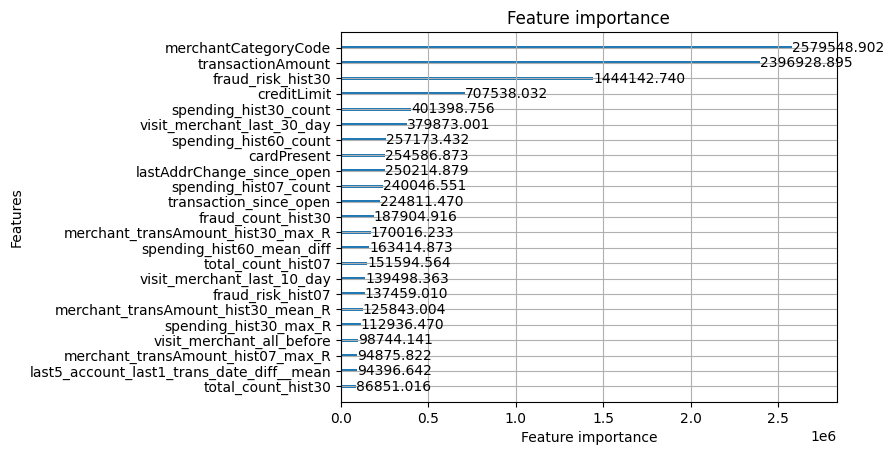

In [76]:
lightgbm.plot_importance(model, importance_type="gain", max_num_features =23)

In [52]:
len(cols)

76

In [66]:
importance_df = pd.DataFrame({'Feature': cols, 'Importance': model.feature_importance()})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

In [67]:
cols = importance_df.Feature.values[:30]

In [91]:
look = data.groupby(['merchantName','transactionDateTime_dt']).size().reset_index()

In [96]:
look.loc[look[0]>10]

merchantName transactionDateTime_dt   0
7623    AMC #128743             2016-01-01  13
7626    AMC #128743             2016-01-04  17
7628    AMC #128743             2016-01-06  14
7635    AMC #128743             2016-01-13  12
7637    AMC #128743             2016-01-15  13
...             ...                    ...  ..
242644  walmart.com             2016-12-26  45
242645  walmart.com             2016-12-27  49
242646  walmart.com             2016-12-28  54
242647  walmart.com             2016-12-29  47
242648  walmart.com             2016-12-30  44

[13063 rows x 3 columns]

In [54]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 3.2 MB/s eta 0:00:00


In [55]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val[cols])

/usr/local/lib/python3.10/dist-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


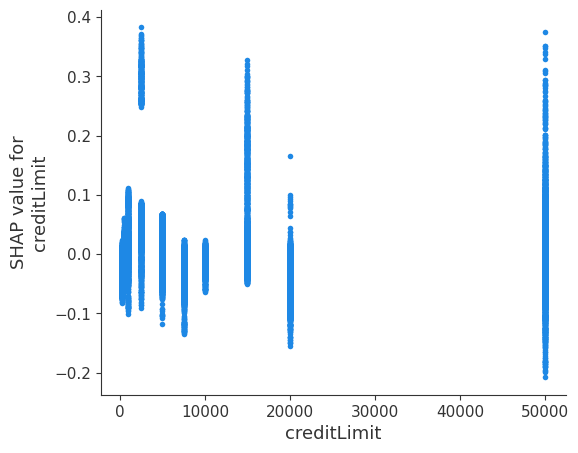

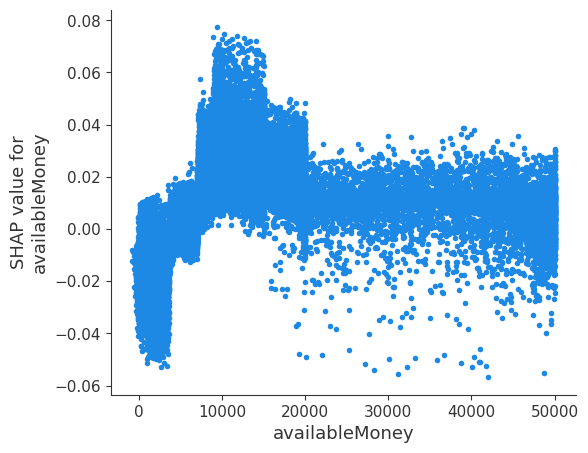

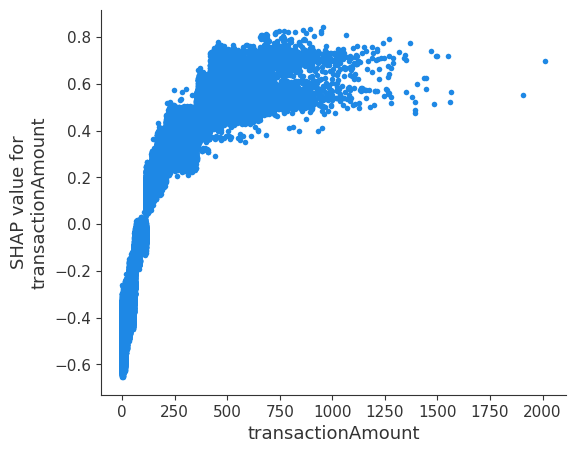

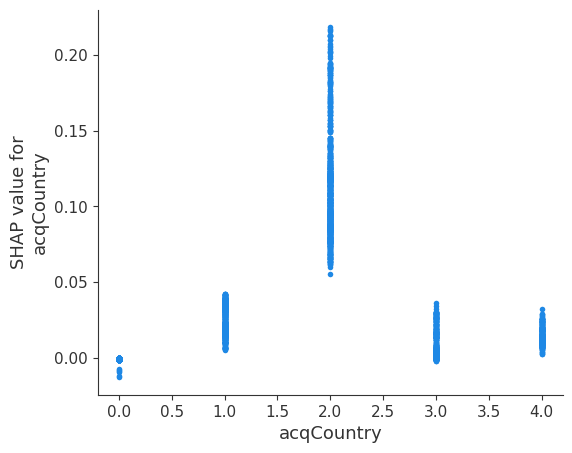

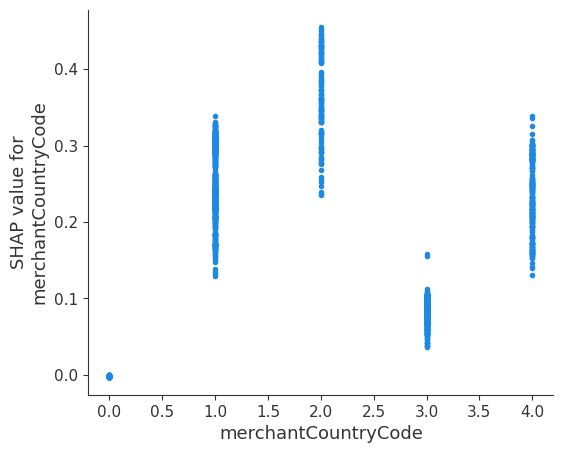

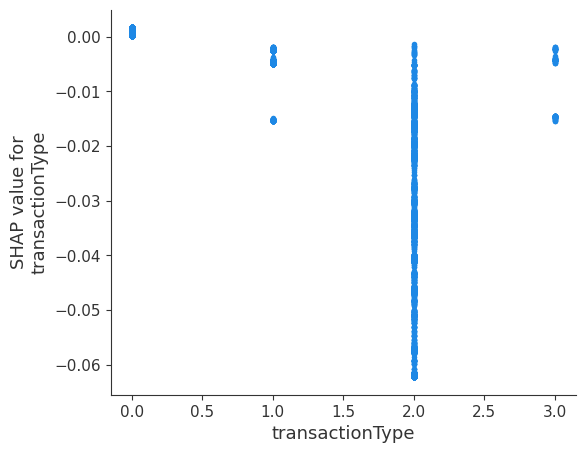

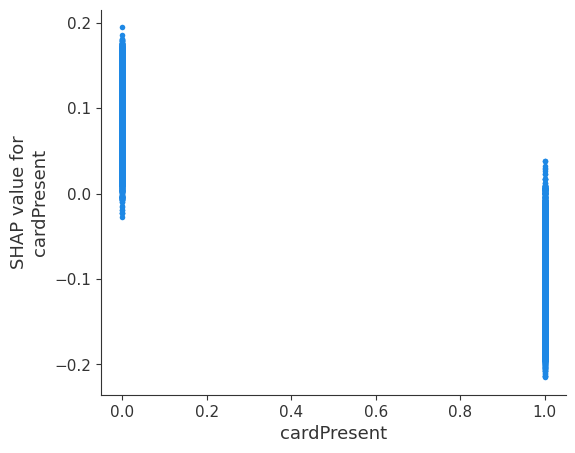

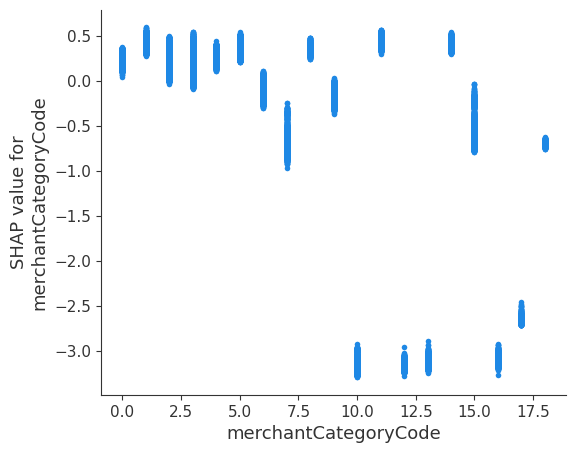

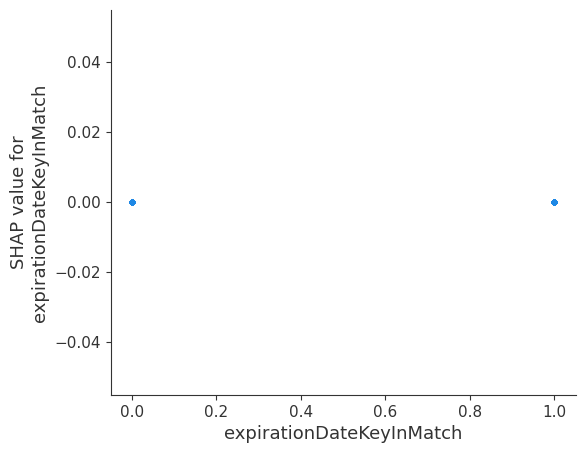

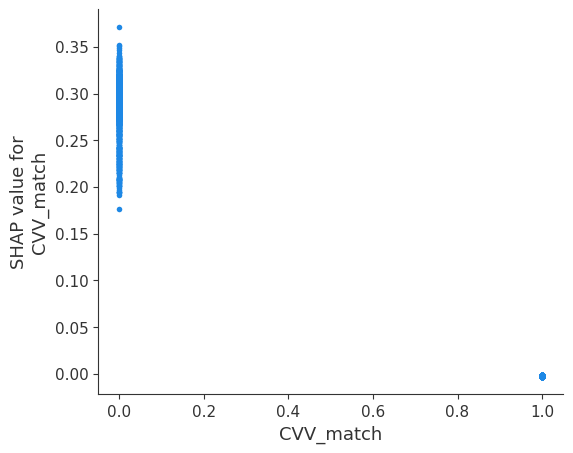

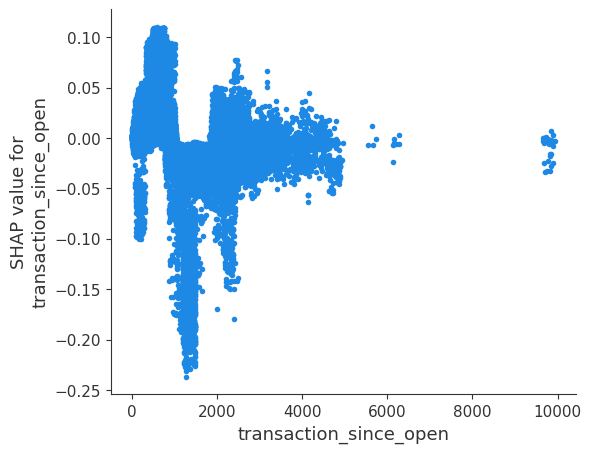

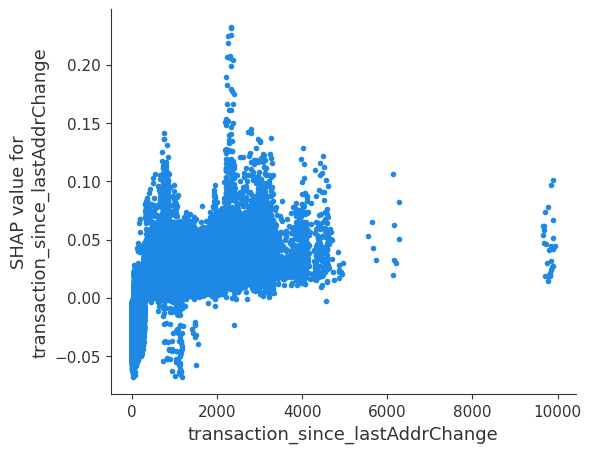

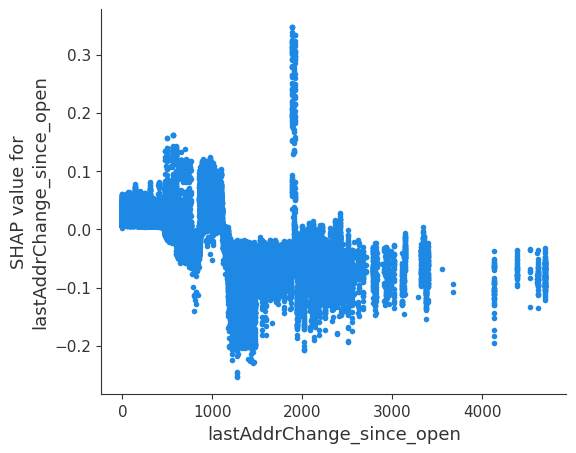

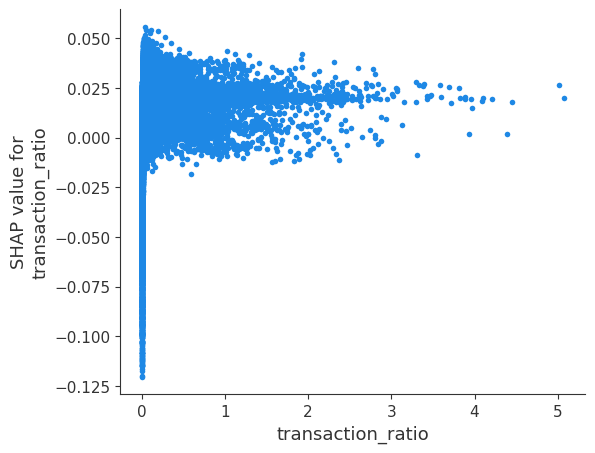

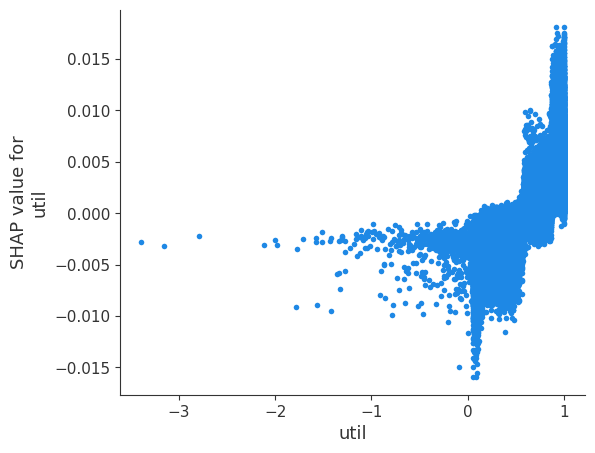

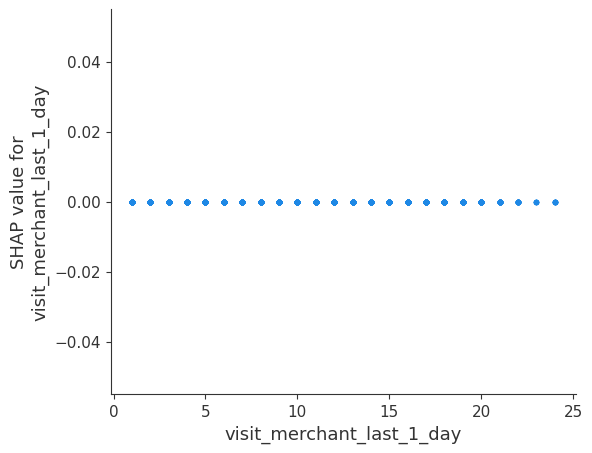

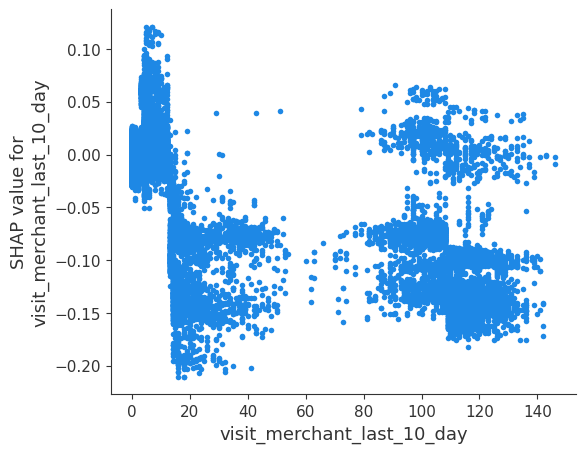

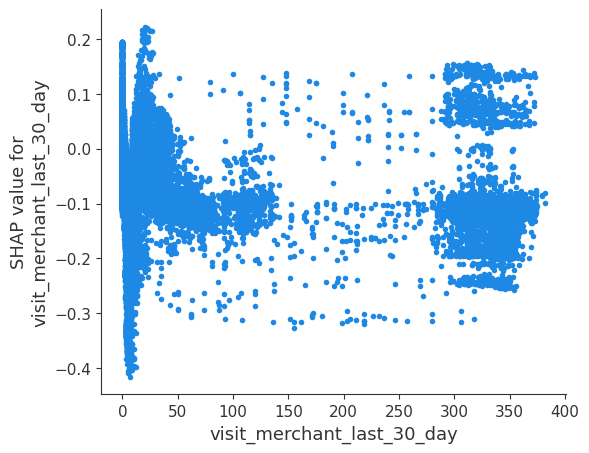

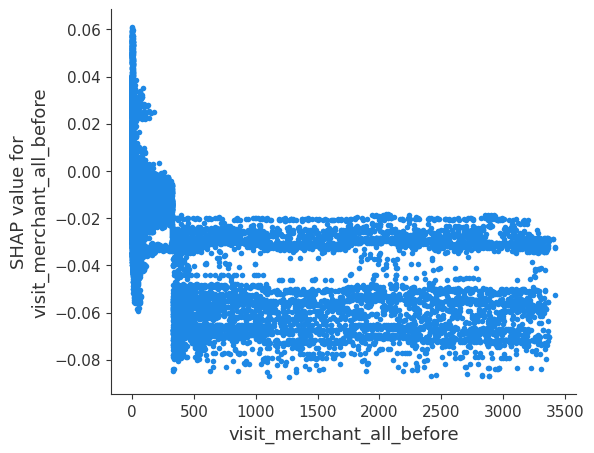

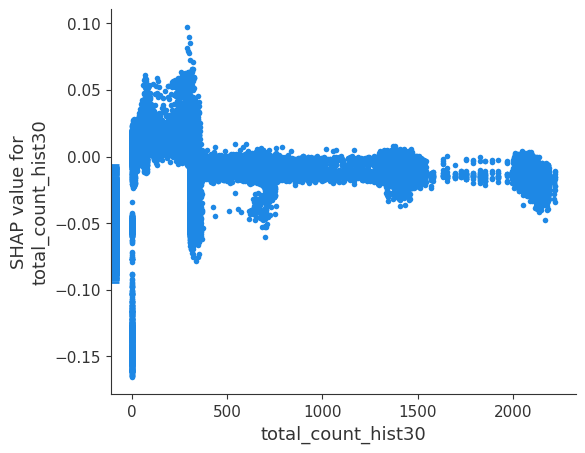

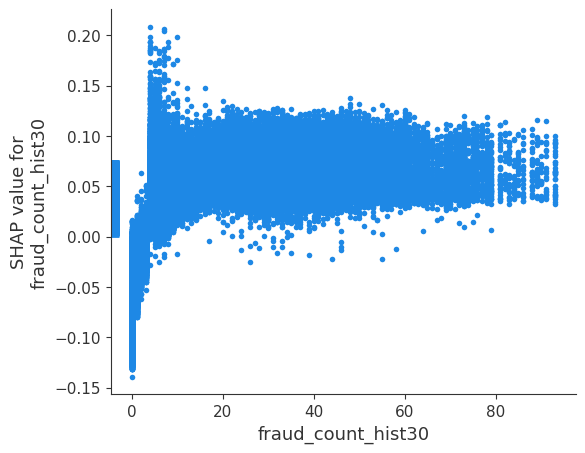

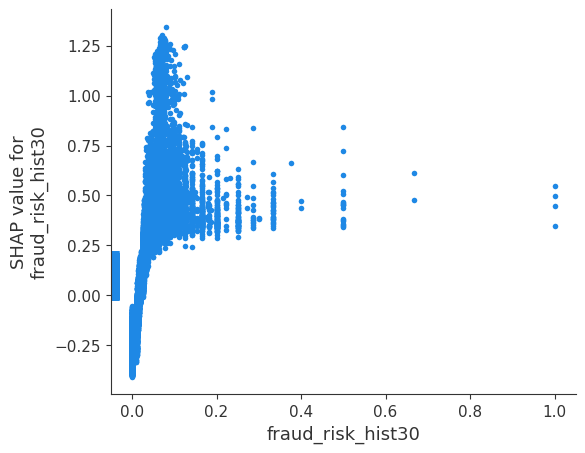

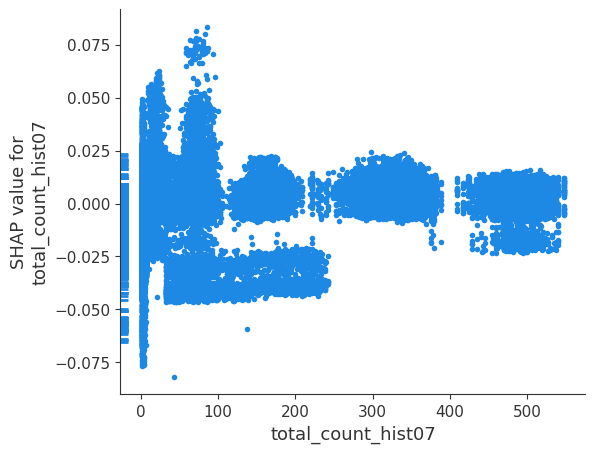

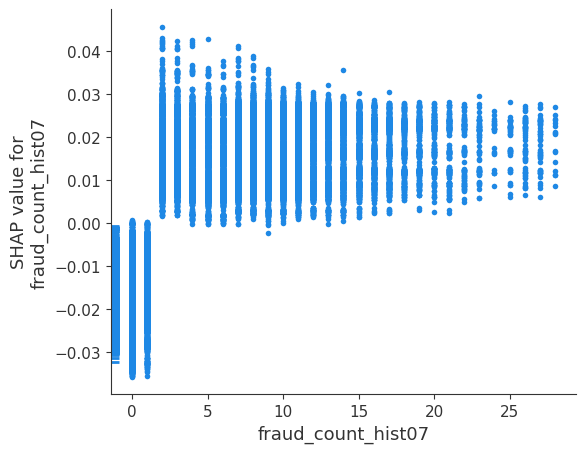

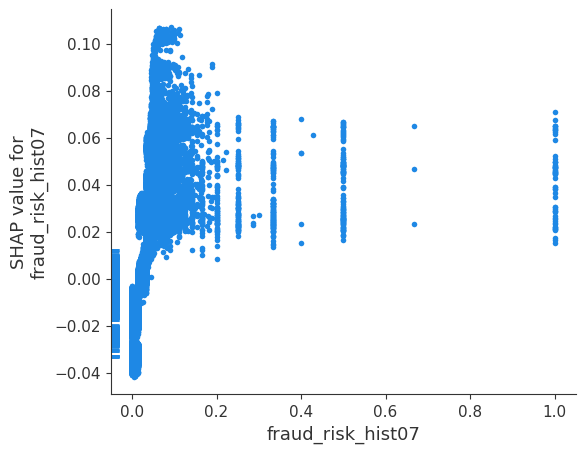

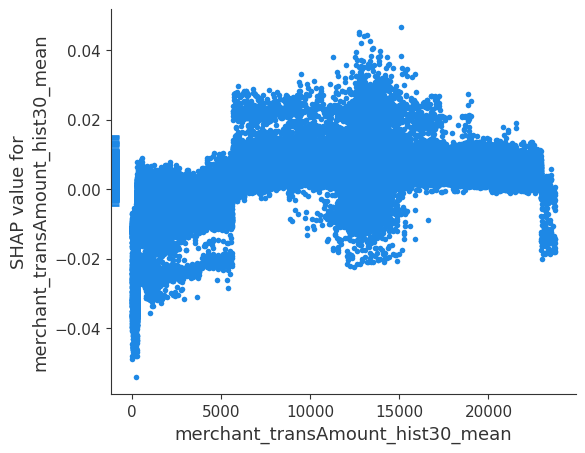

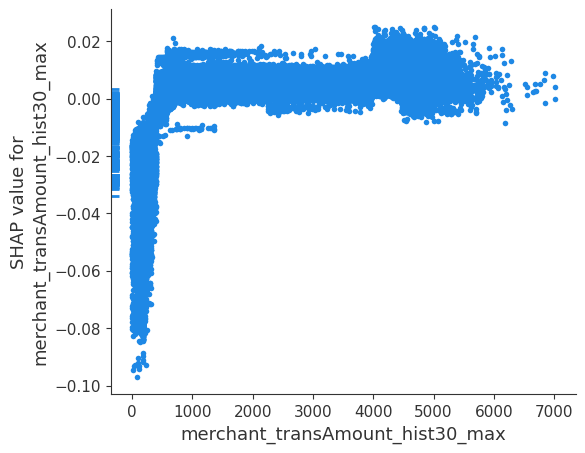

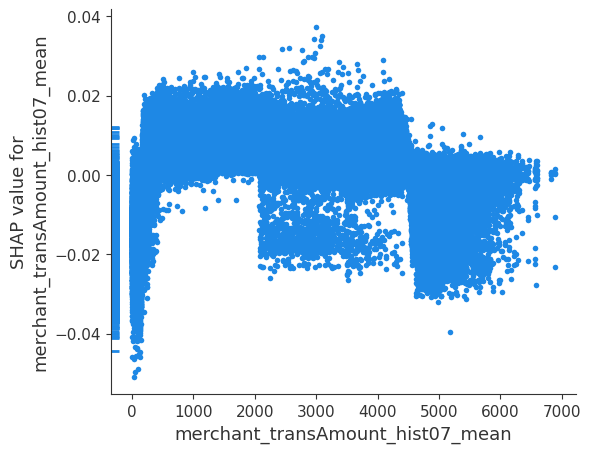

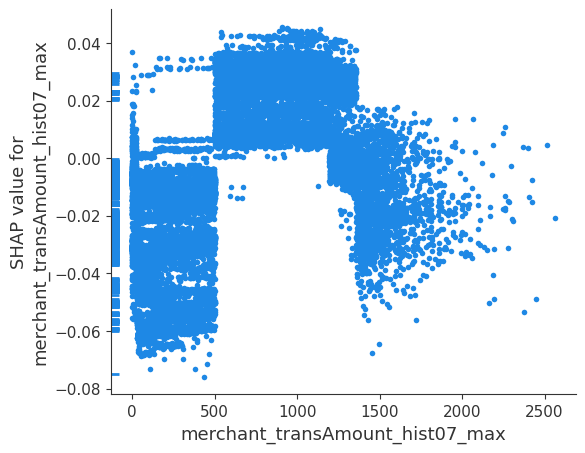

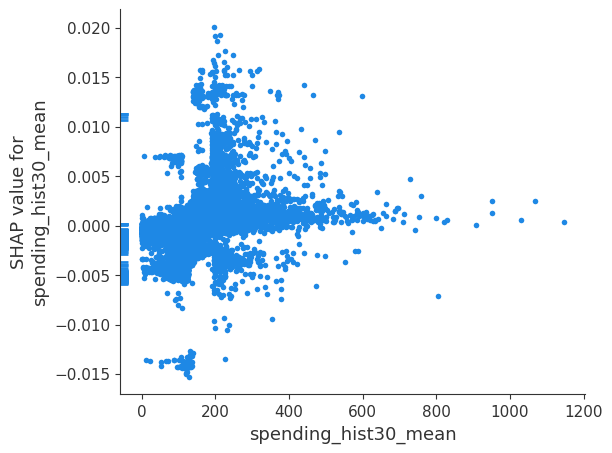

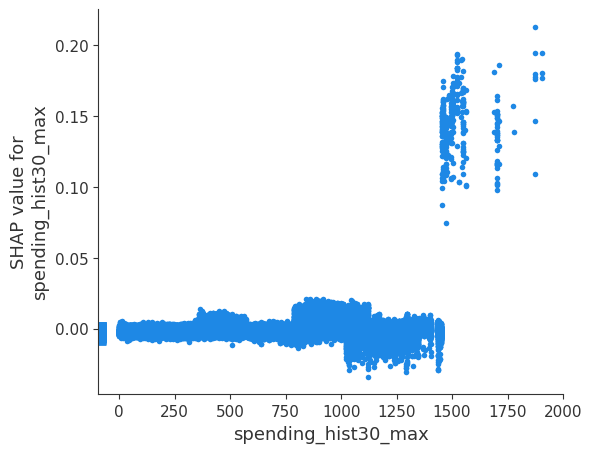

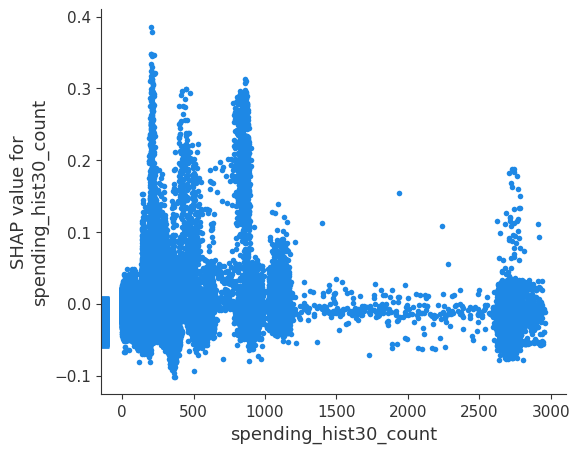

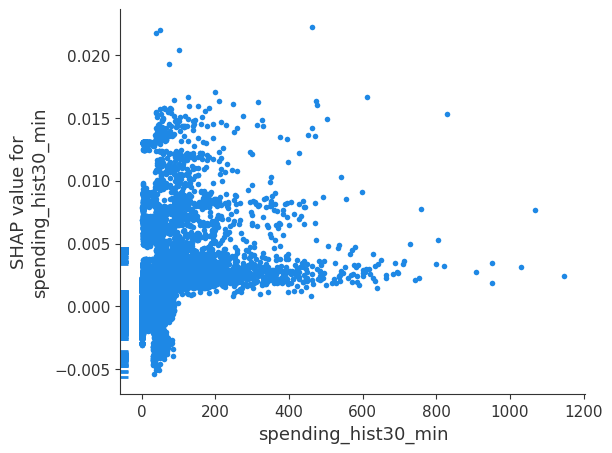

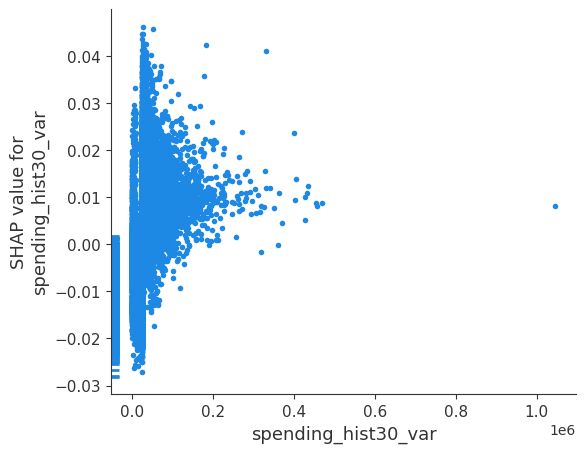

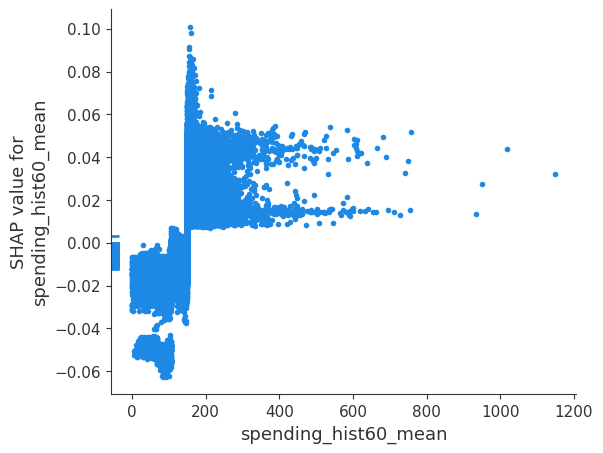

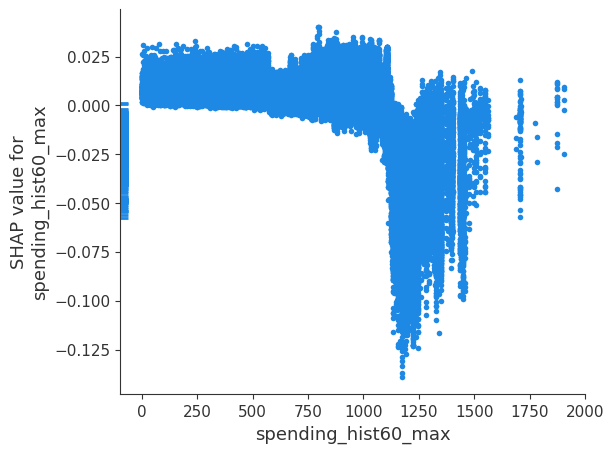

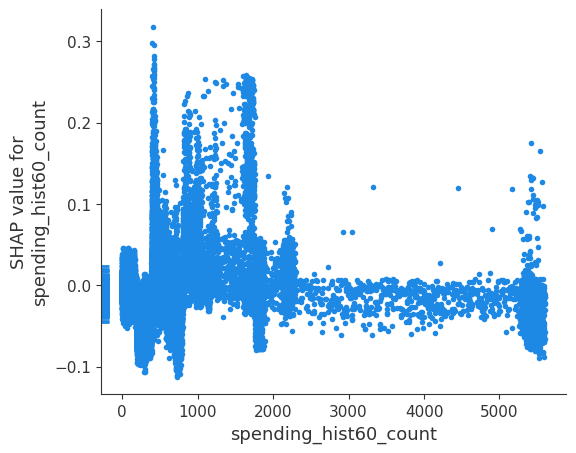

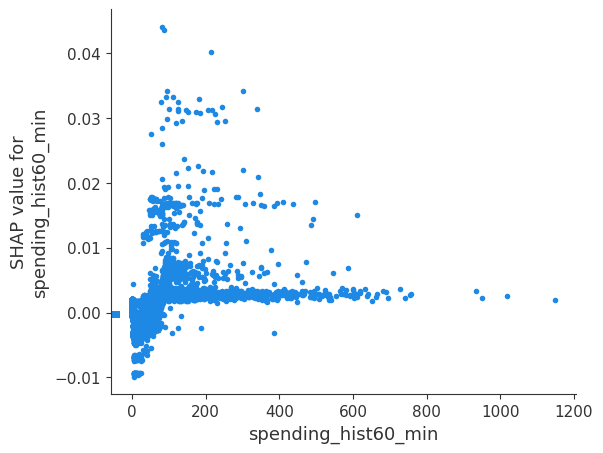

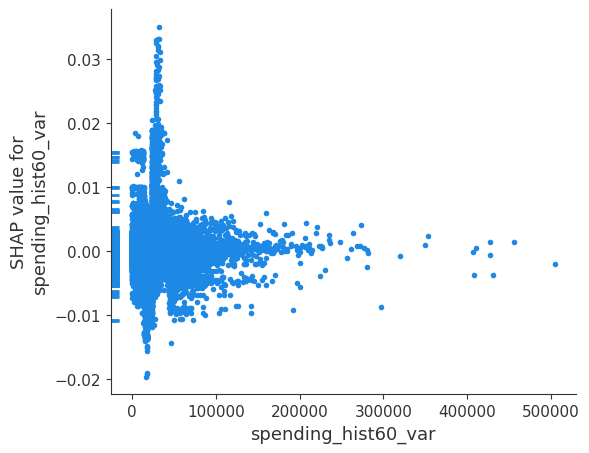

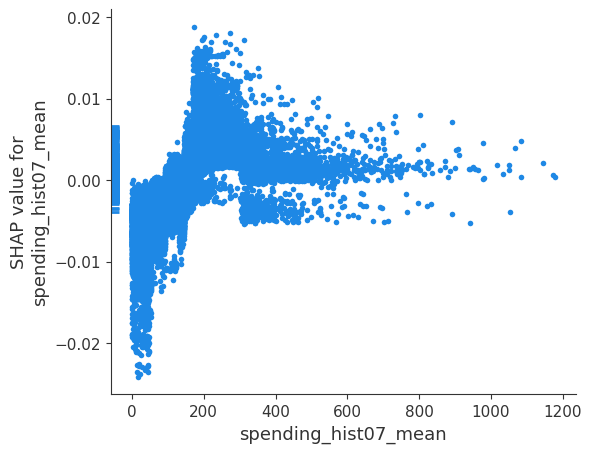

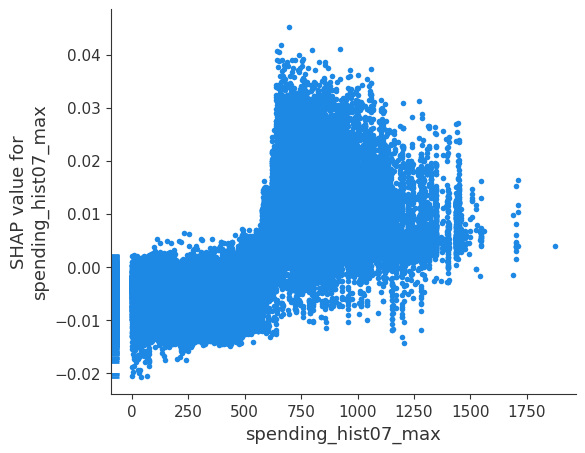

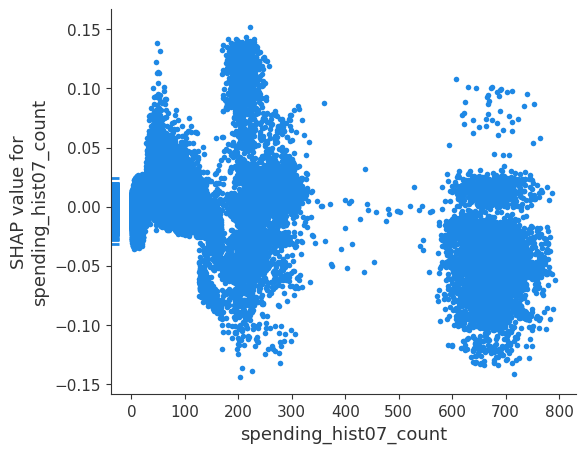

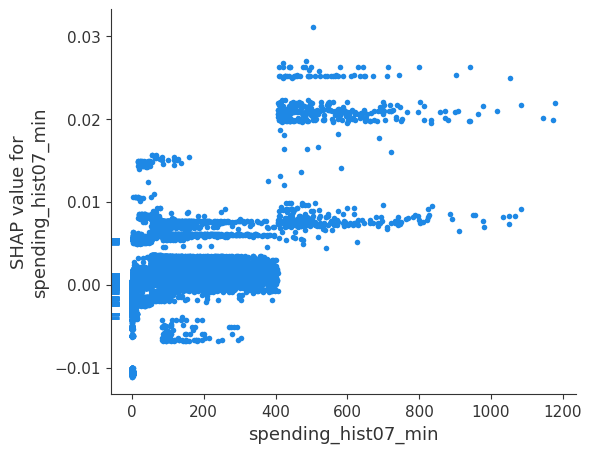

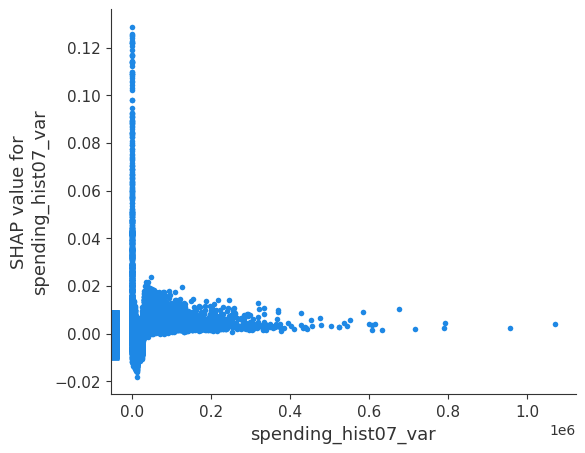

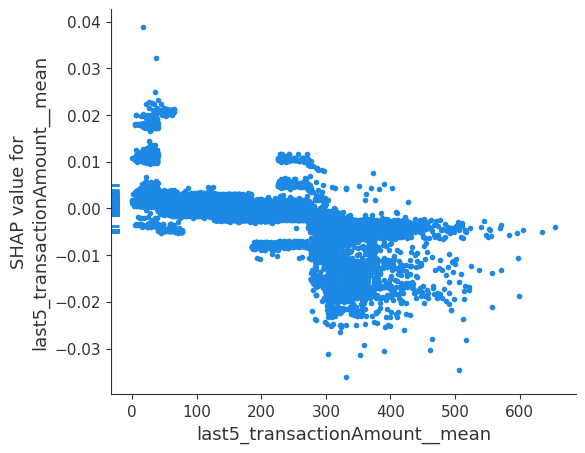

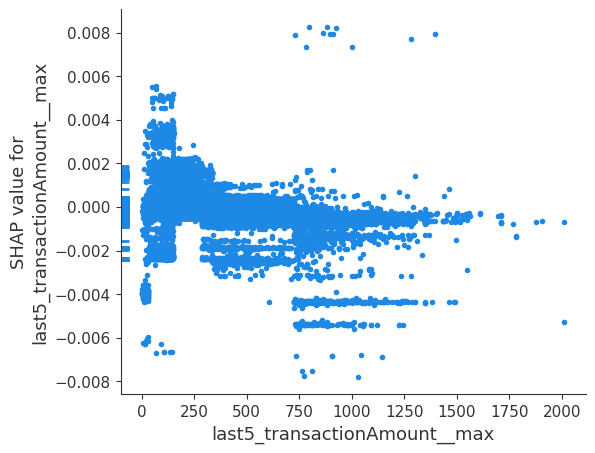

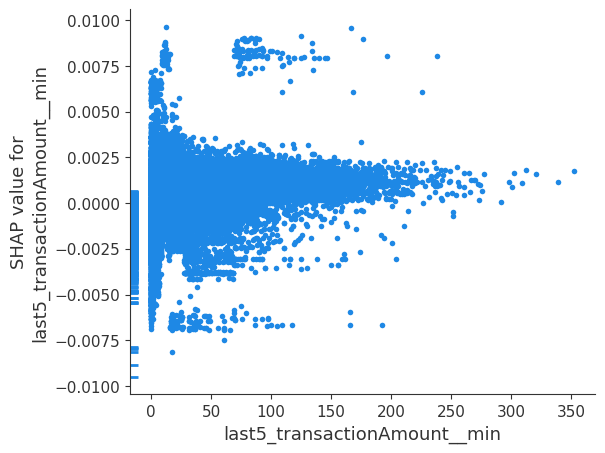

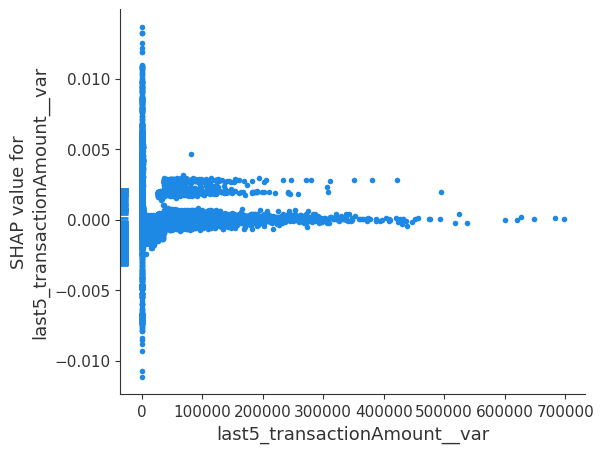

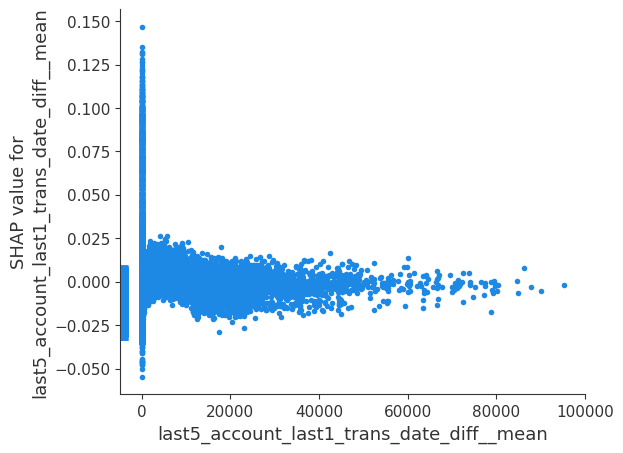

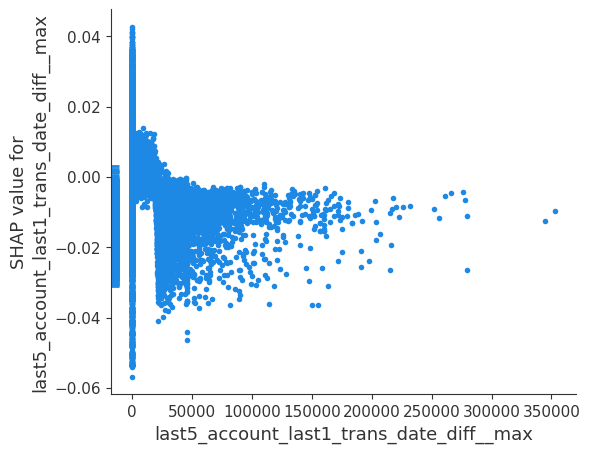

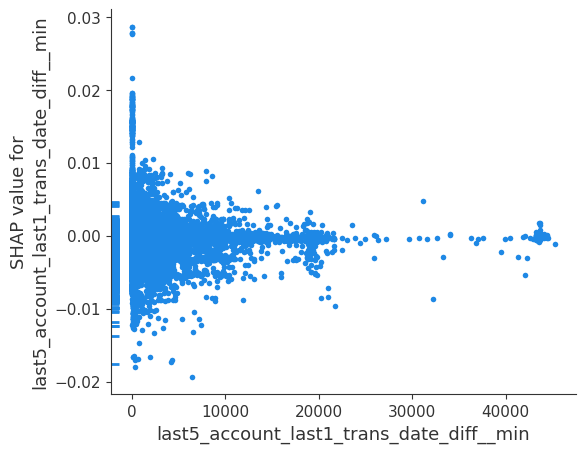

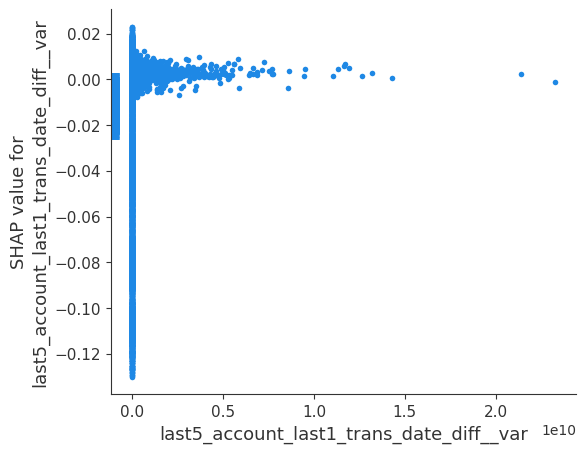

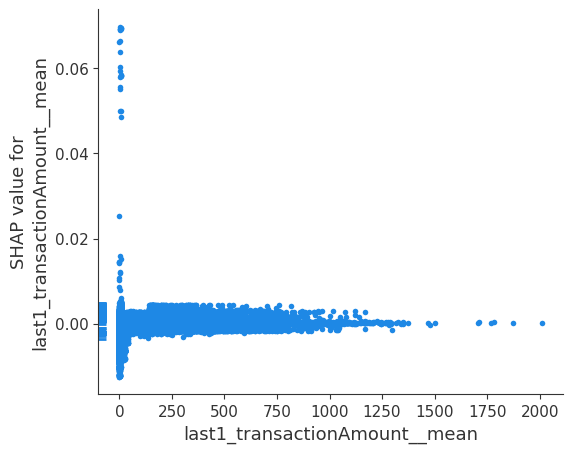

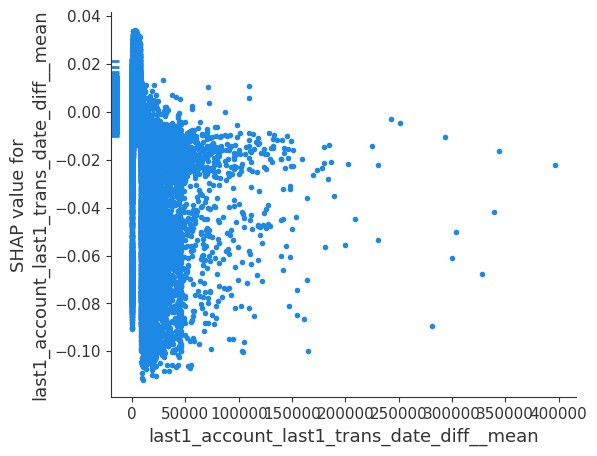

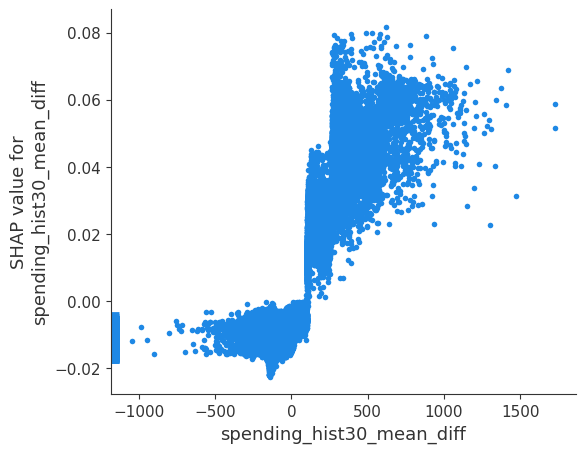

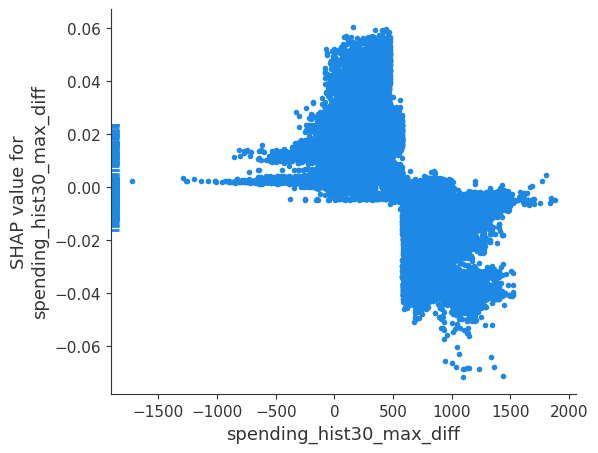

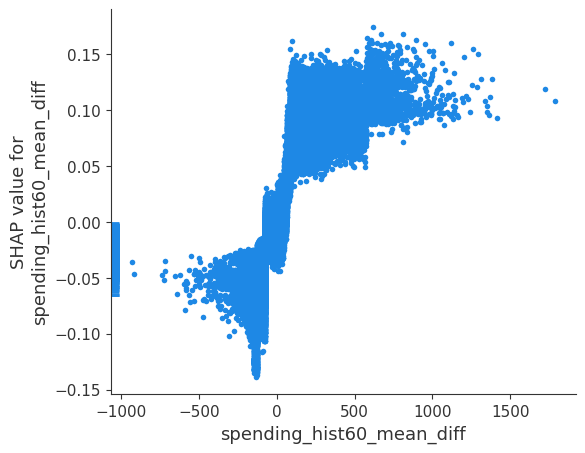

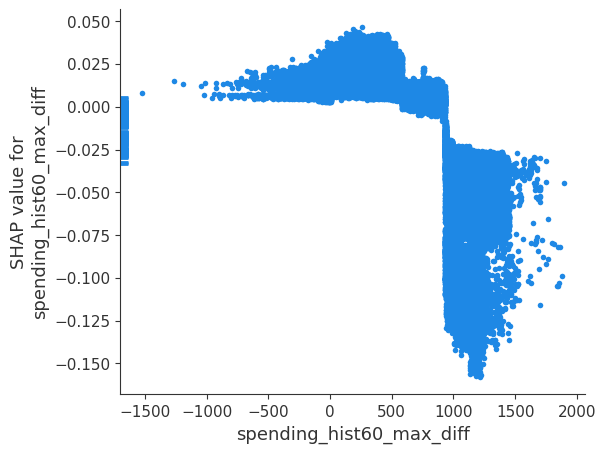

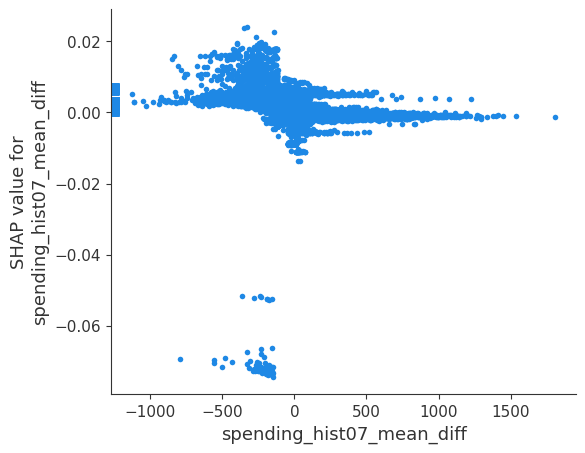

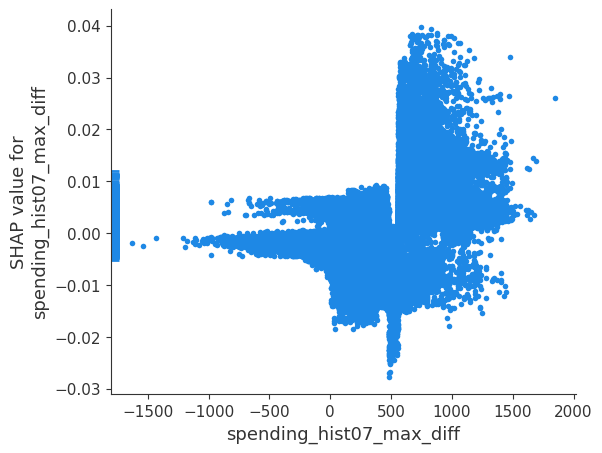

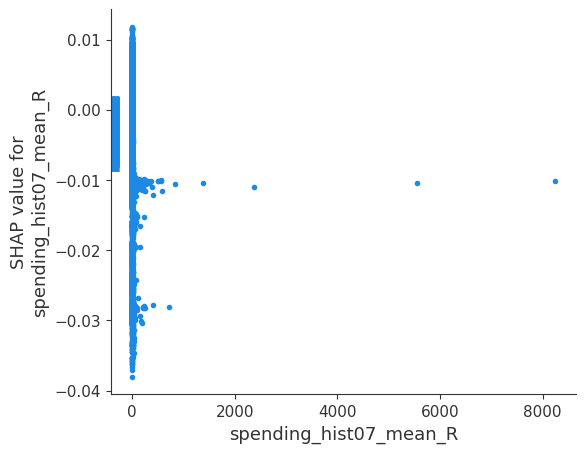

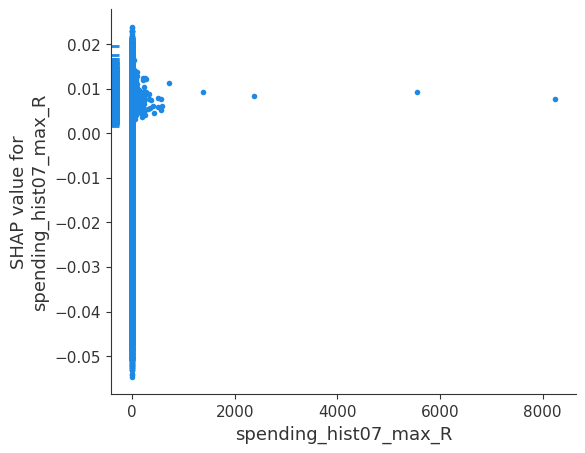

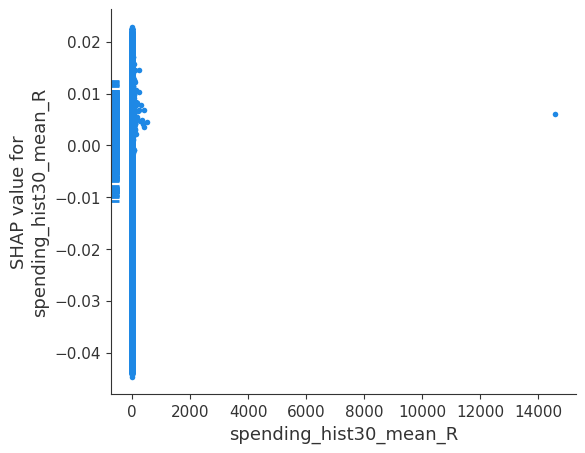

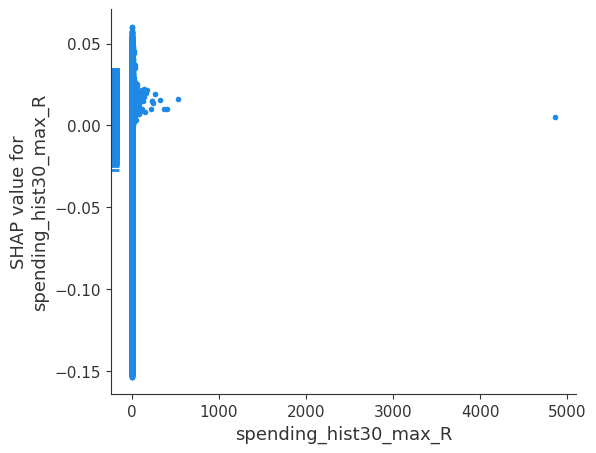

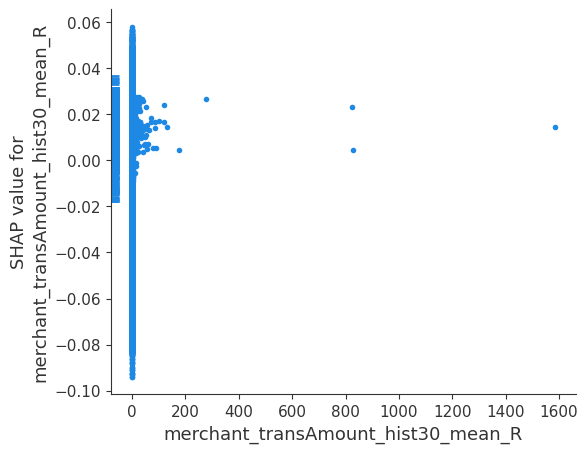

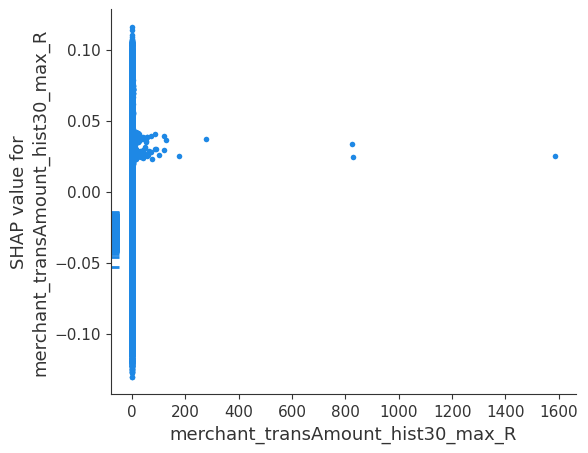

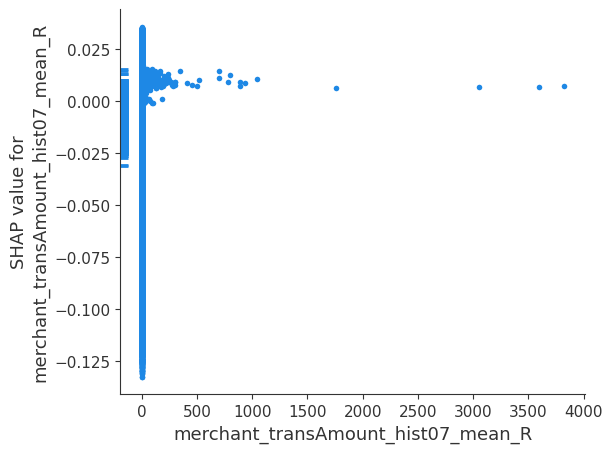

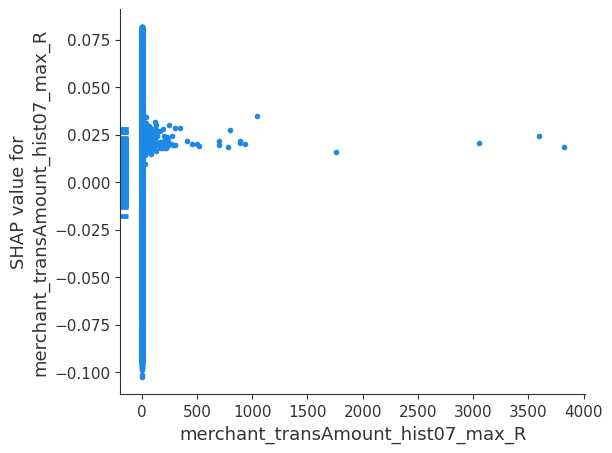

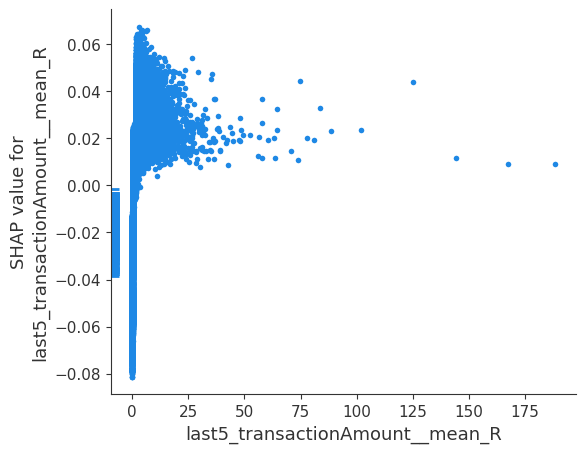

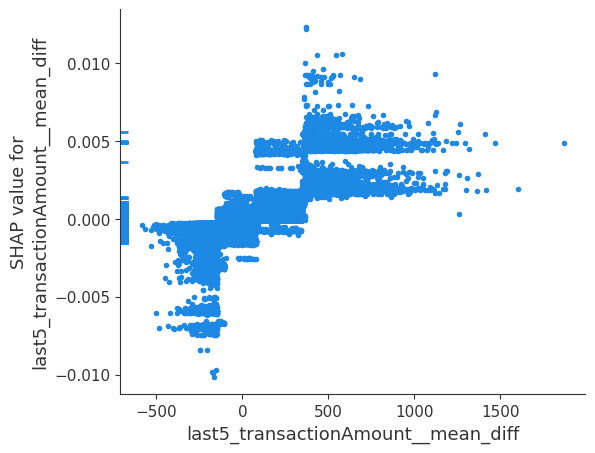

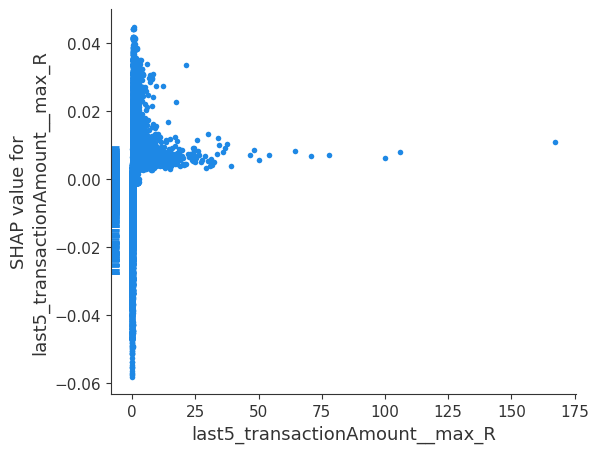

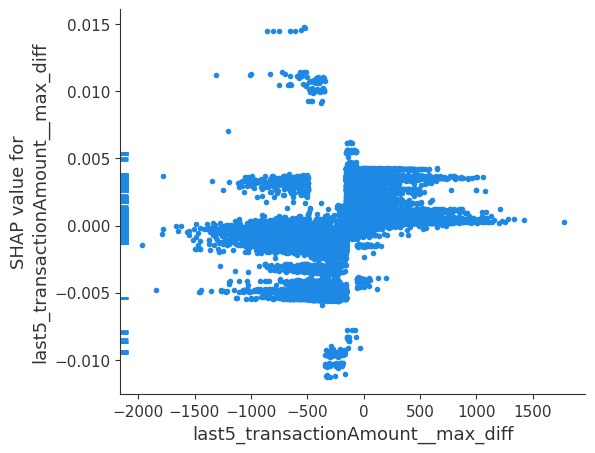

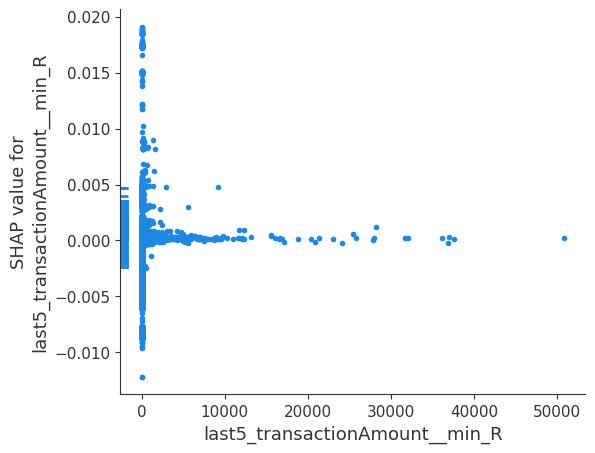

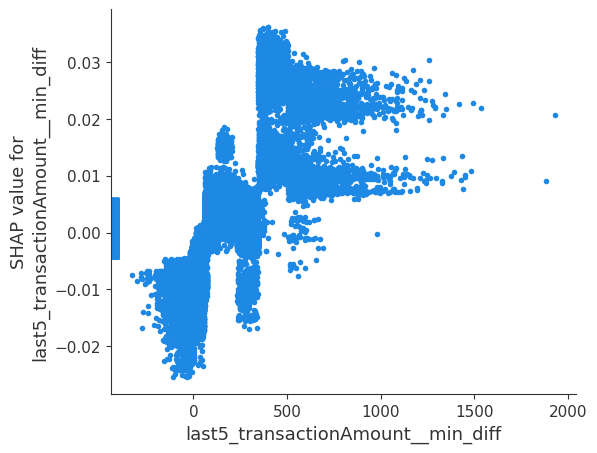

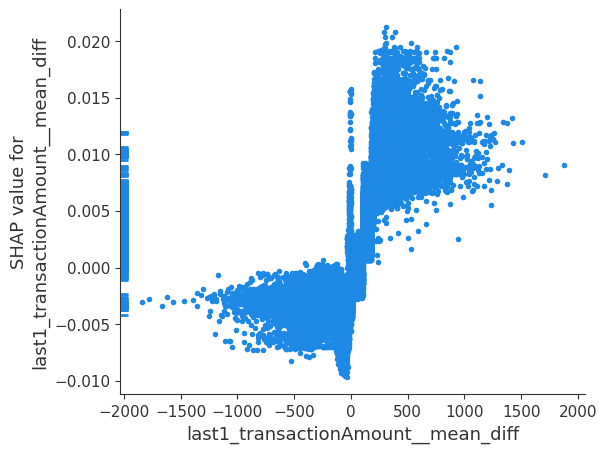

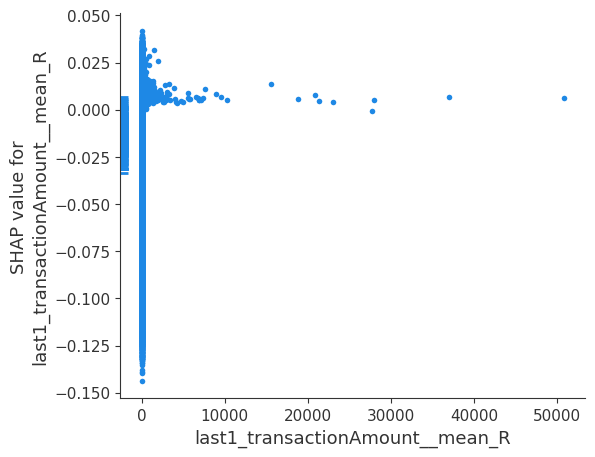

In [63]:
for i, c in enumerate(cols):
  shap.dependence_plot(i, shap_values, X_val[cols], feature_names=cols, interaction_index=None)

In [65]:
cols

['creditLimit',
 'availableMoney',
 'transactionAmount',
 'acqCountry',
 'merchantCountryCode',
 'transactionType',
 'cardPresent',
 'merchantCategoryCode',
 'expirationDateKeyInMatch',
 'CVV_match',
 'transaction_since_open',
 'transaction_since_lastAddrChange',
 'lastAddrChange_since_open',
 'transaction_ratio',
 'util',
 'visit_merchant_last_1_day',
 'visit_merchant_last_10_day',
 'visit_merchant_last_30_day',
 'visit_merchant_all_before',
 'total_count_hist30',
 'fraud_count_hist30',
 'fraud_risk_hist30',
 'total_count_hist07',
 'fraud_count_hist07',
 'fraud_risk_hist07',
 'merchant_transAmount_hist30_mean',
 'merchant_transAmount_hist30_max',
 'merchant_transAmount_hist07_mean',
 'merchant_transAmount_hist07_max',
 'spending_hist30_mean',
 'spending_hist30_max',
 'spending_hist30_count',
 'spending_hist30_min',
 'spending_hist30_var',
 'spending_hist60_mean',
 'spending_hist60_max',
 'spending_hist60_count',
 'spending_hist60_min',
 'spending_hist60_var',
 'spending_hist07_mean',


In [66]:
temp

accountNumber  creditLimit  availableMoney  transactionAmount  \
0           100088067        50000        50000.00             205.13   
1           100088067        50000        49794.87              46.43   
2           100088067        50000        49748.44             378.67   
3           100088067        50000        50000.00              66.07   
4           100088067        50000        49933.93             141.60   
...               ...          ...             ...                ...   
786358      999389635         5000         4921.32             267.62   
786359      999389635         5000         4653.70               4.62   
786360      999389635         5000         4674.08               4.62   
786361      999389635         5000         4694.46               4.62   
786362      999389635         5000         4714.84               4.62   

        currentBalance                    merchantName acqCountry  \
0                 0.00            EZ Putt Putt #982199         US   
1               205.13  Dinosaur Sandwitch Bar #303701         US   
2               251.56                   Mobile eCards         US   
3                 0.00             EZ Putt Putt #40513         US   
4                66.07                34th BBQ #412895         US   
...                ...                             ...        ...   
786358           78.68              Franks Pub #680641         US   
786359          346.30                      Play Store         US   
786360          325.92                      Play Store         US   
786361          305.54                      Play Store         US   
786362          285.16                      Play Store         US   

       merchantCountryCode  cardCVV  enteredCVV  ...  \
0                       US      546         546  ...   
1                       US      546         546  ...   
2                       US      402         402  ...   
3                       US      546         546  ...   
4                       US      546         546  ...   
...                    ...      ...         ...  ...   
786358                  US      140         140  ...   
786359                  US      140         140  ...   
786360                  US      140         140  ...   
786361                  US      140         140  ...   
786362                  US      140         140  ...   

       last5_account_last1_trans_date_diff__mean  \
0                                            NaN   
1                                            NaN   
2                                            NaN   
3                                            NaN   
4                                            NaN   
...                                          ...   
786358                               4240.430000   
786359                               3531.913333   
786360                               4234.276667   
786361                               2611.966667   
786362                               2845.006667   

       last5_account_last1_trans_date_diff__max  \
0                                           NaN   
1                                           NaN   
2                                           NaN   
3                                           NaN   
4                                           NaN   
...                                         ...   
786358                             10957.383333   
786359                             10957.383333   
786360                             10957.383333   
786361                              4561.500000   
786362                              4561.500000   

       last5_account_last1_trans_date_diff__min  \
0                                           NaN   
1                                           NaN   
2                                           NaN   
3                                           NaN   
4                                           NaN   
...                                         ...   
786358                            

In [67]:
import seaborn as sns

In [70]:
temp.groupby('creditLimit').size()

creditLimit
250       34025
500       27097
1000      36430
2500      75429
5000     201863
7500      97913
10000     56889
15000    139307
20000     68629
50000     48781
dtype: int64

In [1]:
import numpy as np